Get best bin sizes from comparing to Travis ages, also adding columns in the end for errors

Prot:   teff,log(prot),abs_g=[350.0, 0.5, 0.17333333333333334]

Rvar:   teff,log(Rvar),abs_g=[100.0, 1.5, 1.0]

In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [2]:
df_prot_s=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')
df_rvar_s=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

df_prot_p=pd.read_pickle('NewData/ProtVP_MS_150_w015_bin_pc.pkl')
df_rvar_p=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin_pc.pkl')


df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')

merg1=['KID','age','Rvar','Prot','teff_calc','Prot_log',
       'logg_y','v_b','w','abs_G','source_id','designation']
merg2=['KID','age','Rvar','teff_calc','Rvar_log','logg','v_b','abs_G','source_id']
df_prot_s=pd.merge(df_isoages,df_prot_s[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_s=pd.merge(df_isoages,df_rvar_s[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_s=df_prot_s.dropna(subset=['age','iso_age'])
df_rvar_s=df_rvar_s.dropna(subset=['age','iso_age'])

#df_prot_s=df_prot_s.loc[df_prot_s['iso_age']<10]
#df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]
#df_prot_s=df_prot_s.loc[abs(df_prot_s['iso_age_err2'])<3]
df_prot_s['iso_age_err']=np.sqrt(df_prot_s['iso_age_err1']**2.+df_prot_s['iso_age_err2']**2.)

df_prot_p=pd.merge(df_isoages,df_prot_p[merg1],left_on='KIC',right_on='KID',how='inner')
df_rvar_p=pd.merge(df_isoages,df_rvar_p[merg2],left_on='KIC',right_on='KID',how='inner')
df_prot_p=df_prot_p.dropna(subset=['age','iso_age'])
df_rvar_p=df_rvar_p.dropna(subset=['age','iso_age'])


In [3]:
df_isoages.columns

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'TAMS\\'],
      dtype='object')

In [12]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    return kin_age,v_to_age(kin_age,p_mr)
    #print(v_to_age(kin_age,p_mr))
    
import time
from tqdm import trange
# get average ages
def getkinAges_err(df,fs,binfs,sampsize=10):
    df=df.dropna(subset=['v_b'])
    bin_low=[i*0.5 for i in binfs]
    bin_hi=[i*1.5 for i in binfs]
    
    bins=np.zeros((len(binfs),sampsize))
    ages=np.zeros((len(df),sampsize))
    for i in range(len(binfs)):
        bins[i,:]=np.linspace(bin_low[i],bin_hi[i],sampsize)
    for i in range(sampsize):
        getkinAges(df,fs,bins[:,i])
        ages[:,i]=df['kin_age']
    getkinAges(df,fs,binfs)
    
    df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 
    return ages


    

In [43]:
#df_prot_s_ruth['AMP_age']

In [37]:

df_prot_s_ruth=pd.read_table('all_rvs.csv',delimiter=',')    
df_prot_s=pd.read_pickle('KinageAllKepler.pkl')
fillin=df_prot_s.loc[df_prot_s['mass']!=df_prot_s['mass']]
df_prot_s['mass'].loc[df_prot_s['KID'].isin(fillin['KID'])]=df_prot_s_ruth.loc[df_prot_s_ruth['KIC'].isin(fillin['KID'])]['mass']

df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')    

#getkinAges(df_prot_s,['teff_calc','Rvar_log','abs_G'],[266.6666666666667, 5.0, 0.01])  


/Users/lucy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3        0.526
40       0.645
57       0.684
61       0.606
73       0.583
         ...  
32697    0.816
32701    0.827
32712    0.795
32746    0.834
32758    0.771
Name: mass, Length: 1151, dtype: float64


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
df_prot_s.columns

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2',
       ...
       'Prot_err', 'Prot_new', 'kepid_x', 'kepid_y', 'X', 'Y', 'z', 'R',
       'Lz_est', 'kin_age_Sharma2020'],
      dtype='object', length=220)

In [15]:
df_prot_s.columns

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2',
       ...
       'Prot_err', 'Prot_new', 'kepid_x', 'kepid_y', 'X', 'Y', 'z', 'R',
       'Lz_est', 'kin_age_Sharma2020'],
      dtype='object', length=220)

In [41]:
df_prot_s[columns_save].to_pickle('minchisq.pkl')

In [40]:
columns_save=['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'KID',
       'age', 'Rvar', 'Prot', 'teff_calc', 'Prot_log', 'v_b', 'w',
       'abs_G', 'source_id', 'designation', 'iso_age_err', 'kin_age',
       'kin_age_err', 'iso_age_ave', 'iso_age_ave_err', 'v_t_err', 'v_b_err',
       'abs_G_err', 'teff_val_err', 'Prot_err', 'Prot_new', 'teff_calc_new',
       'abs_G_new', 'v_b_new', 'kin_age_err_bs', 'vel_dis', 'logg']

In [154]:
df_prot_s=pd.read_pickle('minchisq.pkl')    

In [36]:
df_prot_s['logg']=df_prot_s['logg_y']

In [44]:
df_prot_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Prot_err,Prot_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,logg
0,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.031109,228.925049,0.023,13.773219,4851.256790,6.422569,-0.943424,1.446636,9.785919,4.615
1,893033,0.685,0.027,-0.030,4707.6,87.6,-82.5,4.636,0.018,-0.023,...,0.028509,121.665039,0.214,27.201958,4704.322563,6.665509,-48.411905,2.565540,13.713968,4.607
2,893286,0.853,0.047,-0.057,5297.1,103.4,-98.5,4.522,0.034,-0.044,...,0.052317,215.742676,0.872,28.227418,5362.005131,5.651806,4.180066,1.055713,15.774203,4.603
3,893383,0.912,0.036,-0.051,5680.9,105.1,-102.2,4.526,0.020,-0.031,...,0.027138,43.075684,0.536,21.182943,5680.083288,5.201393,-19.880820,0.994955,8.906897,4.612
4,893559,0.808,0.044,-0.049,5095.3,95.2,-88.7,4.546,0.033,-0.041,...,0.071831,58.006836,0.108,14.880262,5101.814834,5.894823,6.444042,0.810244,14.865115,4.594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,12884971,0.640,0.018,-0.015,4218.2,72.9,-41.3,4.640,0.021,-0.037,...,0.021474,54.750000,0.085,26.017590,4146.281171,7.346681,-29.419907,2.445367,11.495741,4.633
20636,12934465,0.750,0.036,-0.036,4769.3,83.6,-76.0,4.579,0.026,-0.027,...,0.034849,99.989990,1.692,33.685286,4581.850697,6.383114,8.819981,1.253350,13.906501,4.647
20637,12934488,0.953,0.074,-0.070,5667.7,107.6,-102.3,4.346,0.042,-0.042,...,0.015213,104.905029,0.849,52.584489,5714.556863,4.549548,-46.622516,1.447204,11.681465,4.493
20638,12934525,0.829,0.041,-0.054,5264.3,95.3,-90.7,4.555,0.026,-0.039,...,0.052815,139.604980,0.240,25.193911,5073.415445,5.631794,-1.278779,1.049201,13.019659,4.563


## real ages (real chisq)

In [19]:
df_prot_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Prot_err,Prot_new,kepid_x,kepid_y,X,Y,z,R,Lz_est,kin_age_Sharma2020
0,892675,1.038,0.066,-0.076,5929.4,108.9,-108.1,4.385,0.035,-0.043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,893033,0.685,0.027,-0.030,4707.6,87.6,-82.5,4.636,0.018,-0.023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56950,12784183,0.544,0.012,-0.013,3844.2,80.0,-72.9,4.688,0.013,-0.012,...,0.104,18.124777,12784183.0,12784183.0,0.018169,-0.154255,0.047623,8.183285,287.403694,-0.088600
56952,12785321,0.835,0.035,-0.041,4962.2,83.2,-78.8,4.564,0.022,-0.033,...,0.251,33.048234,12785321.0,12785321.0,0.082690,-0.712343,0.214503,8.148507,332.273040,0.017596
56954,12834265,0.685,0.026,-0.022,4356.2,73.4,-68.6,4.613,0.021,-0.018,...,0.042,21.323459,12834265.0,12834265.0,0.048083,-0.413760,0.127588,8.162410,94.361383,1.505106
56955,12884404,1.051,0.062,-0.075,5945.6,127.8,-149.6,4.400,0.036,-0.045,...,1.876,14.959591,12884404.0,12884404.0,0.155333,-1.353919,0.421869,8.157804,218.082184,0.336984


In [23]:
# compare to real ages
import scipy
df_prot_s['Rvar_log']=np.log10(df_prot_s['Rvar'])

protbins=np.linspace(1.,5.,5)
loggbins=np.linspace(0.1,5,5)
tempbins=np.linspace(100.,500.,4)
absg=np.linspace(0.0001,0.05,5)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            for l in absg:
                print(float(count)/float(total))
                count=count+1
                getkinAges(df_prot_s,['teff_calc','Prot_log','Rvar_log','abs_G'],[i,j,k,l])
                stat_df=df_prot_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
                if len(stat_df)<1000:
                    continue
                stat_df=stat_df.loc[stat_df['iso_age']<10]
                stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
                
                chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
                chisq.append(chisq_sing/len(stat_df))
                MAD.append(np.median(stat_df['kin_age']-stat_df['iso_age']/
                                 np.sqrt(np.power(stat_df['kin_age'],2)+np.power(stat_df['iso_age'],2))))
                tempbins_a.append(i)
                protbins_a.append(j)
                loggbins_a.append(k)
                absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  1%|▏         | 279/20714 [00:00<00:07, 2744.50it/s]

0.002


100%|██████████| 20714/20714 [00:06<00:00, 3252.60it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  1%|▏         | 294/20714 [00:00<00:06, 2937.06it/s]

0.004


  2%|▏         | 317/20714 [00:00<00:06, 3169.94it/s]

0.006


  1%|          | 247/20714 [00:00<00:08, 2467.17it/s]

0.008


  2%|▏         | 357/20714 [00:00<00:05, 3568.75it/s]

0.01


  2%|▏         | 323/20714 [00:00<00:06, 3223.55it/s]

0.012


  1%|          | 219/20714 [00:00<00:09, 2184.96it/s]

0.014


  3%|▎         | 692/20714 [00:00<00:05, 3457.03it/s]

0.016


  2%|▏         | 342/20714 [00:00<00:05, 3414.81it/s]

0.018


  1%|▏         | 309/20714 [00:00<00:06, 3085.13it/s]

0.02


  2%|▏         | 340/20714 [00:00<00:05, 3397.66it/s]

0.022


  2%|▏         | 326/20714 [00:00<00:06, 3257.56it/s]

0.024


  3%|▎         | 645/20714 [00:00<00:06, 3280.81it/s]

0.026


  2%|▏         | 345/20714 [00:00<00:05, 3449.66it/s]

0.028


  3%|▎         | 692/20714 [00:00<00:05, 3466.16it/s]

0.03


  2%|▏         | 340/20714 [00:00<00:06, 3385.72it/s]

0.032


  2%|▏         | 321/20714 [00:00<00:06, 3206.25it/s]

0.034


  3%|▎         | 622/20714 [00:00<00:06, 3035.89it/s]

0.036


  3%|▎         | 659/20714 [00:00<00:06, 3280.18it/s]

0.038


  1%|▏         | 307/20714 [00:00<00:06, 3062.95it/s]

0.04


  3%|▎         | 690/20714 [00:00<00:05, 3461.74it/s]

0.042


  3%|▎         | 676/20714 [00:00<00:05, 3366.94it/s]

0.044


  2%|▏         | 338/20714 [00:00<00:06, 3379.33it/s]

0.046


  2%|▏         | 334/20714 [00:00<00:06, 3331.73it/s]

0.048


  2%|▏         | 335/20714 [00:00<00:06, 3348.35it/s]

0.05


  1%|▏         | 262/20714 [00:00<00:07, 2616.03it/s]

0.052


  2%|▏         | 517/20714 [00:00<00:07, 2578.55it/s]

0.054


  1%|          | 126/20714 [00:00<00:16, 1252.00it/s]

0.056


  1%|▏         | 310/20714 [00:00<00:06, 3063.39it/s]

0.058


  3%|▎         | 595/20714 [00:00<00:06, 2983.04it/s]

0.06


  1%|          | 187/20714 [00:00<00:10, 1868.22it/s]

0.062


  1%|          | 239/20714 [00:00<00:08, 2383.06it/s]

0.064


  1%|▏         | 291/20714 [00:00<00:07, 2904.24it/s]

0.066


  2%|▏         | 326/20714 [00:00<00:06, 3255.87it/s]

0.068


  2%|▏         | 339/20714 [00:00<00:06, 3389.83it/s]

0.07


  2%|▏         | 347/20714 [00:00<00:05, 3465.63it/s]

0.072


  2%|▏         | 316/20714 [00:00<00:06, 3157.50it/s]

0.074


  2%|▏         | 326/20714 [00:00<00:06, 3252.19it/s]

0.076


  1%|          | 252/20714 [00:00<00:08, 2513.97it/s]

0.078


  2%|▏         | 324/20714 [00:00<00:06, 3236.09it/s]

0.08


  2%|▏         | 357/20714 [00:00<00:05, 3568.11it/s]

0.082


  3%|▎         | 582/20714 [00:00<00:07, 2815.38it/s]

0.084


  3%|▎         | 585/20714 [00:00<00:06, 2886.75it/s]

0.086


  2%|▏         | 348/20714 [00:00<00:05, 3478.83it/s]

0.088


  2%|▏         | 328/20714 [00:00<00:06, 3270.77it/s]

0.09


  2%|▏         | 348/20714 [00:00<00:05, 3479.62it/s]

0.092


  1%|          | 225/20714 [00:00<00:09, 2248.31it/s]

0.094


  2%|▏         | 363/20714 [00:00<00:05, 3620.69it/s]

0.096


  1%|▏         | 304/20714 [00:00<00:06, 3036.63it/s]

0.098


  3%|▎         | 624/20714 [00:00<00:06, 3034.89it/s]

0.1


  4%|▎         | 735/20714 [00:00<00:05, 3690.85it/s]

0.102


  1%|▏         | 288/20714 [00:00<00:07, 2873.62it/s]

0.104


  2%|▏         | 350/20714 [00:00<00:05, 3492.22it/s]

0.106


  2%|▏         | 359/20714 [00:00<00:05, 3583.91it/s]

0.108


  2%|▏         | 320/20714 [00:00<00:06, 3194.35it/s]

0.11


  2%|▏         | 360/20714 [00:00<00:05, 3598.78it/s]

0.112


  2%|▏         | 366/20714 [00:00<00:05, 3655.82it/s]

0.114


  3%|▎         | 699/20714 [00:00<00:05, 3485.59it/s]

0.116


  2%|▏         | 351/20714 [00:00<00:05, 3507.65it/s]

0.118


  2%|▏         | 353/20714 [00:00<00:05, 3528.42it/s]

0.12


  2%|▏         | 370/20714 [00:00<00:05, 3696.74it/s]

0.122


  2%|▏         | 369/20714 [00:00<00:05, 3685.43it/s]

0.124


  2%|▏         | 370/20714 [00:00<00:05, 3692.27it/s]

0.126


  1%|          | 247/20714 [00:00<00:08, 2465.17it/s]

0.128


  2%|▏         | 356/20714 [00:00<00:05, 3554.93it/s]

0.13


  1%|          | 231/20714 [00:00<00:08, 2306.56it/s]

0.132


  1%|▏         | 268/20714 [00:00<00:07, 2669.94it/s]

0.134


  2%|▏         | 364/20714 [00:00<00:05, 3635.86it/s]

0.136


  1%|▏         | 284/20714 [00:00<00:07, 2839.89it/s]

0.138


  3%|▎         | 711/20714 [00:00<00:05, 3528.02it/s]

0.14


  2%|▏         | 329/20714 [00:00<00:06, 3272.40it/s]

0.142


  2%|▏         | 350/20714 [00:00<00:05, 3494.34it/s]

0.144


  2%|▏         | 364/20714 [00:00<00:05, 3629.69it/s]

0.146


  2%|▏         | 341/20714 [00:00<00:05, 3409.17it/s]

0.148


  2%|▏         | 324/20714 [00:00<00:06, 3239.91it/s]

0.15


  3%|▎         | 681/20714 [00:00<00:06, 3289.57it/s]

0.152


  2%|▏         | 348/20714 [00:00<00:05, 3458.24it/s]

0.154


  2%|▏         | 374/20714 [00:00<00:05, 3737.12it/s]

0.156


  2%|▏         | 362/20714 [00:00<00:05, 3616.61it/s]

0.158


  2%|▏         | 317/20714 [00:00<00:06, 3162.82it/s]

0.16


  2%|▏         | 373/20714 [00:00<00:05, 3722.34it/s]

0.162


  2%|▏         | 367/20714 [00:00<00:05, 3661.98it/s]

0.164


  3%|▎         | 689/20714 [00:00<00:05, 3441.04it/s]

0.166


  3%|▎         | 662/20714 [00:00<00:06, 3326.42it/s]

0.168


  3%|▎         | 701/20714 [00:00<00:05, 3506.55it/s]

0.17


  2%|▏         | 362/20714 [00:00<00:05, 3610.53it/s]

0.172


  2%|▏         | 368/20714 [00:00<00:05, 3679.92it/s]

0.174


  2%|▏         | 353/20714 [00:00<00:05, 3527.78it/s]

0.176


  3%|▎         | 680/20714 [00:00<00:05, 3462.23it/s]

0.178


  2%|▏         | 332/20714 [00:00<00:06, 3306.15it/s]

0.18


  2%|▏         | 358/20714 [00:00<00:05, 3579.61it/s]

0.182


  2%|▏         | 373/20714 [00:00<00:05, 3729.59it/s]

0.184


  2%|▏         | 320/20714 [00:00<00:06, 3183.39it/s]

0.186


  2%|▏         | 360/20714 [00:00<00:05, 3598.66it/s]

0.188


  1%|▏         | 304/20714 [00:00<00:06, 3036.56it/s]

0.19


  2%|▏         | 353/20714 [00:00<00:05, 3528.28it/s]

0.192


  2%|▏         | 367/20714 [00:00<00:05, 3669.04it/s]

0.194


  2%|▏         | 343/20714 [00:00<00:05, 3423.50it/s]

0.196


  2%|▏         | 312/20714 [00:00<00:06, 3112.20it/s]

0.198


  1%|▏         | 286/20714 [00:00<00:07, 2859.29it/s]

0.2


  3%|▎         | 623/20714 [00:00<00:06, 3071.40it/s]

0.202


  2%|▏         | 343/20714 [00:00<00:05, 3424.00it/s]

0.204


  3%|▎         | 680/20714 [00:00<00:05, 3411.04it/s]

0.206


  3%|▎         | 687/20714 [00:00<00:05, 3437.55it/s]

0.208


  2%|▏         | 341/20714 [00:00<00:05, 3403.88it/s]

0.21


  2%|▏         | 340/20714 [00:00<00:06, 3392.10it/s]

0.212


  2%|▏         | 344/20714 [00:00<00:05, 3437.94it/s]

0.214


  3%|▎         | 661/20714 [00:00<00:06, 3299.44it/s]

0.216


  3%|▎         | 630/20714 [00:00<00:06, 3226.04it/s]

0.218


  2%|▏         | 338/20714 [00:00<00:06, 3374.67it/s]

0.22


  2%|▏         | 345/20714 [00:00<00:05, 3445.49it/s]

0.222


  2%|▏         | 345/20714 [00:00<00:05, 3446.97it/s]

0.224


  1%|▏         | 268/20714 [00:00<00:07, 2675.02it/s]

0.226


  2%|▏         | 342/20714 [00:00<00:05, 3411.13it/s]

0.228


  2%|▏         | 335/20714 [00:00<00:06, 3342.81it/s]

0.23


  2%|▏         | 344/20714 [00:00<00:05, 3433.85it/s]

0.232


  3%|▎         | 635/20714 [00:00<00:06, 3100.10it/s]

0.234


  1%|▏         | 310/20714 [00:00<00:06, 3092.58it/s]

0.236


  3%|▎         | 664/20714 [00:00<00:06, 3327.53it/s]

0.238


  2%|▏         | 338/20714 [00:00<00:06, 3379.60it/s]

0.24


  2%|▏         | 344/20714 [00:00<00:05, 3430.74it/s]

0.242


  3%|▎         | 672/20714 [00:00<00:05, 3364.00it/s]

0.244


  2%|▏         | 339/20714 [00:00<00:06, 3389.40it/s]

0.246


  3%|▎         | 657/20714 [00:00<00:06, 3274.36it/s]

0.248


  2%|▏         | 333/20714 [00:00<00:06, 3328.43it/s]

0.25


  2%|▏         | 336/20714 [00:00<00:06, 3357.11it/s]

0.252


  2%|▏         | 338/20714 [00:00<00:06, 3370.87it/s]

0.254


  3%|▎         | 676/20714 [00:00<00:05, 3391.42it/s]

0.256


  3%|▎         | 669/20714 [00:00<00:05, 3346.30it/s]

0.258


  2%|▏         | 339/20714 [00:00<00:06, 3388.70it/s]

0.26


  2%|▏         | 346/20714 [00:00<00:05, 3458.10it/s]

0.262


  2%|▏         | 332/20714 [00:00<00:06, 3311.92it/s]

0.264


  2%|▏         | 335/20714 [00:00<00:06, 3349.67it/s]

0.266


  3%|▎         | 661/20714 [00:00<00:06, 3289.22it/s]

0.268


  2%|▏         | 326/20714 [00:00<00:06, 3250.94it/s]

0.27


  3%|▎         | 679/20714 [00:00<00:05, 3405.47it/s]

0.272


  1%|          | 215/20714 [00:00<00:09, 2146.69it/s]

0.274


  2%|▏         | 335/20714 [00:00<00:06, 3345.56it/s]

0.276


  2%|▏         | 329/20714 [00:00<00:06, 3287.10it/s]

0.278


  1%|▏         | 273/20714 [00:00<00:07, 2729.77it/s]

0.28


  3%|▎         | 668/20714 [00:00<00:05, 3345.66it/s]

0.282


  2%|▏         | 335/20714 [00:00<00:06, 3346.72it/s]

0.284


  2%|▏         | 327/20714 [00:00<00:06, 3269.50it/s]

0.286


  2%|▏         | 321/20714 [00:00<00:06, 3207.07it/s]

0.288


  2%|▏         | 316/20714 [00:00<00:06, 3157.44it/s]

0.29


  2%|▏         | 334/20714 [00:00<00:06, 3339.40it/s]

0.292


  2%|▏         | 342/20714 [00:00<00:05, 3413.62it/s]

0.294


  2%|▏         | 337/20714 [00:00<00:06, 3364.45it/s]

0.296


  2%|▏         | 324/20714 [00:00<00:06, 3232.66it/s]

0.298


  2%|▏         | 330/20714 [00:00<00:06, 3298.45it/s]

0.3


  2%|▏         | 336/20714 [00:00<00:06, 3355.07it/s]

0.302


  2%|▏         | 342/20714 [00:00<00:05, 3414.29it/s]

0.304


  3%|▎         | 677/20714 [00:00<00:05, 3389.79it/s]

0.306


  2%|▏         | 340/20714 [00:00<00:06, 3394.77it/s]

0.308


  2%|▏         | 335/20714 [00:00<00:06, 3349.06it/s]

0.31


  3%|▎         | 690/20714 [00:00<00:05, 3448.75it/s]

0.312


  3%|▎         | 663/20714 [00:00<00:06, 3313.87it/s]

0.314


  2%|▏         | 340/20714 [00:00<00:05, 3399.35it/s]

0.316


  1%|          | 213/20714 [00:00<00:09, 2125.43it/s]

0.318


  2%|▏         | 321/20714 [00:00<00:06, 3200.97it/s]

0.32


  3%|▎         | 682/20714 [00:00<00:05, 3398.15it/s]

0.322


  3%|▎         | 669/20714 [00:00<00:05, 3353.22it/s]

0.324


  3%|▎         | 660/20714 [00:00<00:06, 3320.50it/s]

0.326


  3%|▎         | 659/20714 [00:00<00:06, 3294.18it/s]

0.328


  3%|▎         | 580/20714 [00:00<00:07, 2805.18it/s]

0.33


  1%|▏         | 310/20714 [00:00<00:06, 3094.86it/s]

0.332


  3%|▎         | 664/20714 [00:00<00:06, 3341.18it/s]

0.334


  3%|▎         | 669/20714 [00:00<00:05, 3341.03it/s]

0.336


  2%|▏         | 332/20714 [00:00<00:06, 3314.63it/s]

0.338


  3%|▎         | 550/20714 [00:00<00:07, 2814.93it/s]

0.34


  3%|▎         | 672/20714 [00:00<00:05, 3348.74it/s]

0.342


  2%|▏         | 333/20714 [00:00<00:06, 3321.74it/s]

0.344


  3%|▎         | 661/20714 [00:00<00:06, 3306.75it/s]

0.346


  2%|▏         | 326/20714 [00:00<00:06, 3258.40it/s]

0.348


  2%|▏         | 330/20714 [00:00<00:06, 3291.40it/s]

0.35


  3%|▎         | 675/20714 [00:00<00:05, 3388.24it/s]

0.352


  1%|▏         | 282/20714 [00:00<00:07, 2819.01it/s]

0.354


  3%|▎         | 662/20714 [00:00<00:06, 3291.05it/s]

0.356


  2%|▏         | 339/20714 [00:00<00:06, 3386.75it/s]

0.358


  2%|▏         | 339/20714 [00:00<00:06, 3389.15it/s]

0.36


  3%|▎         | 673/20714 [00:00<00:05, 3371.00it/s]

0.362


  2%|▏         | 333/20714 [00:00<00:06, 3327.27it/s]

0.364


  2%|▏         | 330/20714 [00:00<00:06, 3295.81it/s]

0.366


  3%|▎         | 667/20714 [00:00<00:06, 3339.31it/s]

0.368


  2%|▏         | 328/20714 [00:00<00:06, 3278.98it/s]

0.37


  3%|▎         | 681/20714 [00:00<00:05, 3412.01it/s]

0.372


  2%|▏         | 327/20714 [00:00<00:06, 3262.14it/s]

0.374


  3%|▎         | 647/20714 [00:00<00:06, 3246.41it/s]

0.376


  2%|▏         | 322/20714 [00:00<00:06, 3213.61it/s]

0.378


  2%|▏         | 318/20714 [00:00<00:06, 3175.88it/s]

0.38


  2%|▏         | 337/20714 [00:00<00:06, 3365.25it/s]

0.382


  1%|▏         | 301/20714 [00:00<00:06, 3005.55it/s]

0.384


  2%|▏         | 333/20714 [00:00<00:06, 3322.16it/s]

0.386


  3%|▎         | 648/20714 [00:00<00:06, 3248.65it/s]

0.388


  1%|▏         | 269/20714 [00:00<00:07, 2688.42it/s]

0.39


  3%|▎         | 688/20714 [00:00<00:05, 3445.60it/s]

0.392


  3%|▎         | 667/20714 [00:00<00:05, 3346.74it/s]

0.394


  3%|▎         | 599/20714 [00:00<00:06, 3096.74it/s]

0.396


  2%|▏         | 332/20714 [00:00<00:06, 3310.59it/s]

0.398


  3%|▎         | 645/20714 [00:00<00:06, 3223.94it/s]

0.4


  3%|▎         | 689/20714 [00:00<00:05, 3434.32it/s]

0.402


  2%|▏         | 341/20714 [00:00<00:05, 3402.28it/s]

0.404


  1%|▏         | 275/20714 [00:00<00:07, 2747.39it/s]

0.406


  2%|▏         | 341/20714 [00:00<00:05, 3404.48it/s]

0.408


  2%|▏         | 335/20714 [00:00<00:06, 3347.48it/s]

0.41


  3%|▎         | 673/20714 [00:00<00:05, 3381.72it/s]

0.412


  2%|▏         | 340/20714 [00:00<00:06, 3393.43it/s]

0.414


  3%|▎         | 667/20714 [00:00<00:05, 3341.57it/s]

0.416


  2%|▏         | 328/20714 [00:00<00:06, 3276.99it/s]

0.418


  2%|▏         | 327/20714 [00:00<00:06, 3267.58it/s]

0.42


  2%|▏         | 334/20714 [00:00<00:06, 3334.40it/s]

0.422


  2%|▏         | 332/20714 [00:00<00:06, 3316.92it/s]

0.424


  2%|▏         | 326/20714 [00:00<00:06, 3251.19it/s]

0.426


  2%|▏         | 328/20714 [00:00<00:06, 3273.94it/s]

0.428


  2%|▏         | 327/20714 [00:00<00:06, 3267.38it/s]

0.43


  1%|▏         | 294/20714 [00:00<00:06, 2932.43it/s]

0.432


  2%|▏         | 338/20714 [00:00<00:06, 3377.80it/s]

0.434


  3%|▎         | 664/20714 [00:00<00:06, 3334.93it/s]

0.436


  2%|▏         | 314/20714 [00:00<00:06, 3136.77it/s]

0.438


  3%|▎         | 618/20714 [00:00<00:06, 3137.33it/s]

0.44


  2%|▏         | 346/20714 [00:00<00:05, 3458.20it/s]

0.442


  2%|▏         | 337/20714 [00:00<00:06, 3368.65it/s]

0.444


  3%|▎         | 654/20714 [00:00<00:06, 3274.46it/s]

0.446


  2%|▏         | 330/20714 [00:00<00:06, 3298.61it/s]

0.448


  3%|▎         | 650/20714 [00:00<00:06, 3246.70it/s]

0.45


  3%|▎         | 690/20714 [00:00<00:05, 3466.94it/s]

0.452


  3%|▎         | 673/20714 [00:00<00:05, 3381.35it/s]

0.454


  3%|▎         | 682/20714 [00:00<00:05, 3410.79it/s]

0.456


  2%|▏         | 337/20714 [00:00<00:06, 3362.74it/s]

0.458


  3%|▎         | 597/20714 [00:00<00:06, 3056.49it/s]

0.46


  2%|▏         | 346/20714 [00:00<00:05, 3451.33it/s]

0.462


  2%|▏         | 334/20714 [00:00<00:06, 3331.44it/s]

0.464


  3%|▎         | 600/20714 [00:00<00:06, 2910.26it/s]

0.466


  3%|▎         | 655/20714 [00:00<00:06, 3292.88it/s]

0.468


  2%|▏         | 324/20714 [00:00<00:06, 3234.76it/s]

0.47


  2%|▏         | 342/20714 [00:00<00:05, 3411.16it/s]

0.472


  3%|▎         | 669/20714 [00:00<00:05, 3350.28it/s]

0.474


  2%|▏         | 329/20714 [00:00<00:06, 3283.40it/s]

0.476


  2%|▏         | 322/20714 [00:00<00:06, 3212.38it/s]

0.478


  2%|▏         | 322/20714 [00:00<00:06, 3216.84it/s]

0.48


  2%|▏         | 338/20714 [00:00<00:06, 3373.55it/s]

0.482


  2%|▏         | 339/20714 [00:00<00:06, 3382.83it/s]

0.484


  3%|▎         | 662/20714 [00:00<00:06, 3311.23it/s]

0.486


  3%|▎         | 591/20714 [00:00<00:06, 2905.84it/s]

0.488


  3%|▎         | 654/20714 [00:00<00:06, 3269.55it/s]

0.49


  3%|▎         | 677/20714 [00:00<00:05, 3389.70it/s]

0.492


  3%|▎         | 675/20714 [00:00<00:05, 3381.96it/s]

0.494


  2%|▏         | 334/20714 [00:00<00:06, 3338.60it/s]

0.496


  3%|▎         | 656/20714 [00:00<00:06, 3270.83it/s]

0.498


  3%|▎         | 643/20714 [00:00<00:06, 3193.62it/s]

0.5


  2%|▏         | 342/20714 [00:00<00:05, 3417.71it/s]

0.502


  1%|▏         | 278/20714 [00:00<00:07, 2779.97it/s]

0.504


  2%|▏         | 345/20714 [00:00<00:05, 3440.99it/s]

0.506


  2%|▏         | 343/20714 [00:00<00:05, 3426.84it/s]

0.508


  3%|▎         | 664/20714 [00:00<00:06, 3294.84it/s]

0.51


  2%|▏         | 343/20714 [00:00<00:05, 3423.53it/s]

0.512


  2%|▏         | 340/20714 [00:00<00:06, 3390.84it/s]

0.514


  2%|▏         | 328/20714 [00:00<00:06, 3275.84it/s]

0.516


  2%|▏         | 323/20714 [00:00<00:06, 3223.84it/s]

0.518


  2%|▏         | 327/20714 [00:00<00:06, 3264.02it/s]

0.52


  2%|▏         | 349/20714 [00:00<00:05, 3484.98it/s]

0.522


  2%|▏         | 342/20714 [00:00<00:05, 3415.76it/s]

0.524


  2%|▏         | 323/20714 [00:00<00:06, 3224.93it/s]

0.526


  2%|▏         | 472/20714 [00:00<00:08, 2444.23it/s]

0.528


  1%|▏         | 260/20714 [00:00<00:07, 2595.74it/s]

0.53


  1%|          | 252/20714 [00:00<00:08, 2513.04it/s]

0.532


  1%|          | 194/20714 [00:00<00:10, 1933.14it/s]

0.534


  1%|▏         | 310/20714 [00:00<00:06, 3092.83it/s]

0.536


  0%|          | 63/20714 [00:00<00:32, 627.73it/s]

0.538


  2%|▏         | 324/20714 [00:00<00:06, 3234.85it/s]

0.54


  3%|▎         | 667/20714 [00:00<00:06, 3300.04it/s]

0.542


  3%|▎         | 634/20714 [00:00<00:06, 3218.27it/s]

0.544


  2%|▏         | 323/20714 [00:00<00:06, 3227.13it/s]

0.546


  2%|▏         | 331/20714 [00:00<00:06, 3307.84it/s]

0.548


  2%|▏         | 313/20714 [00:00<00:06, 3126.60it/s]

0.55


  2%|▏         | 330/20714 [00:00<00:06, 3293.02it/s]

0.552


  2%|▏         | 343/20714 [00:00<00:05, 3427.46it/s]

0.554


  2%|▏         | 345/20714 [00:00<00:05, 3444.21it/s]

0.556


  2%|▏         | 331/20714 [00:00<00:06, 3309.40it/s]

0.558


  2%|▏         | 328/20714 [00:00<00:06, 3270.02it/s]

0.56


  2%|▏         | 344/20714 [00:00<00:05, 3439.08it/s]

0.562


  2%|▏         | 342/20714 [00:00<00:05, 3418.83it/s]

0.564


  2%|▏         | 339/20714 [00:00<00:06, 3384.24it/s]

0.566


  3%|▎         | 656/20714 [00:00<00:06, 3292.98it/s]

0.568


  3%|▎         | 649/20714 [00:00<00:06, 3252.29it/s]

0.57


  2%|▏         | 340/20714 [00:00<00:05, 3399.56it/s]

0.572


  2%|▏         | 334/20714 [00:00<00:06, 3339.46it/s]

0.574


  2%|▏         | 333/20714 [00:00<00:06, 3322.66it/s]

0.576


  2%|▏         | 330/20714 [00:00<00:06, 3292.13it/s]

0.578


  2%|▏         | 318/20714 [00:00<00:06, 3171.66it/s]

0.58


  3%|▎         | 680/20714 [00:00<00:05, 3383.35it/s]

0.582


  1%|▏         | 298/20714 [00:00<00:06, 2972.72it/s]

0.584


  2%|▏         | 331/20714 [00:00<00:06, 3301.19it/s]

0.586


  3%|▎         | 651/20714 [00:00<00:06, 3255.86it/s]

0.588


  1%|          | 238/20714 [00:00<00:08, 2374.13it/s]

0.59


  2%|▏         | 325/20714 [00:00<00:06, 3249.64it/s]

0.592


  3%|▎         | 668/20714 [00:00<00:05, 3345.26it/s]

0.594


  2%|▏         | 331/20714 [00:00<00:06, 3300.46it/s]

0.596


  2%|▏         | 312/20714 [00:00<00:06, 3116.89it/s]

0.598


  3%|▎         | 637/20714 [00:00<00:06, 3200.04it/s]

0.6


  3%|▎         | 582/20714 [00:00<00:07, 2832.07it/s]

0.602


  2%|▏         | 339/20714 [00:00<00:06, 3384.04it/s]

0.604


  1%|▏         | 303/20714 [00:00<00:06, 3024.16it/s]

0.606


  2%|▏         | 337/20714 [00:00<00:06, 3362.94it/s]

0.608


  3%|▎         | 675/20714 [00:00<00:05, 3375.44it/s]

0.61


  3%|▎         | 669/20714 [00:00<00:06, 3332.90it/s]

0.612


  2%|▏         | 340/20714 [00:00<00:05, 3398.92it/s]

0.614


  2%|▏         | 317/20714 [00:00<00:06, 3167.47it/s]

0.616


  2%|▏         | 323/20714 [00:00<00:06, 3220.54it/s]

0.618


  2%|▏         | 320/20714 [00:00<00:06, 3199.18it/s]

0.62


  2%|▏         | 340/20714 [00:00<00:06, 3395.21it/s]

0.622


  3%|▎         | 670/20714 [00:00<00:05, 3353.17it/s]

0.624


  2%|▏         | 331/20714 [00:00<00:06, 3307.26it/s]

0.626


  2%|▏         | 325/20714 [00:00<00:06, 3246.88it/s]

0.628


  1%|▏         | 306/20714 [00:00<00:06, 3053.80it/s]

0.63


  2%|▏         | 341/20714 [00:00<00:05, 3408.26it/s]

0.632


  3%|▎         | 670/20714 [00:00<00:05, 3355.44it/s]

0.634


  3%|▎         | 651/20714 [00:00<00:06, 3270.00it/s]

0.636


  3%|▎         | 644/20714 [00:00<00:06, 3201.70it/s]

0.638


  3%|▎         | 648/20714 [00:00<00:06, 3253.80it/s]

0.64


  3%|▎         | 680/20714 [00:00<00:05, 3409.65it/s]

0.642


  3%|▎         | 600/20714 [00:00<00:07, 2847.39it/s]

0.644


  2%|▏         | 332/20714 [00:00<00:06, 3318.57it/s]

0.646


  3%|▎         | 632/20714 [00:00<00:06, 3112.46it/s]

0.648


  2%|▏         | 324/20714 [00:00<00:06, 3239.77it/s]

0.65


  3%|▎         | 669/20714 [00:00<00:06, 3330.08it/s]

0.652


  3%|▎         | 644/20714 [00:00<00:06, 3259.10it/s]

0.654


  3%|▎         | 604/20714 [00:00<00:06, 3046.66it/s]

0.656


  2%|▏         | 330/20714 [00:00<00:06, 3299.64it/s]

0.658


  2%|▏         | 326/20714 [00:00<00:06, 3257.07it/s]

0.66


  2%|▏         | 345/20714 [00:00<00:05, 3447.76it/s]

0.662


  2%|▏         | 341/20714 [00:00<00:05, 3402.88it/s]

0.664


  2%|▏         | 331/20714 [00:00<00:06, 3301.91it/s]

0.666


  2%|▏         | 331/20714 [00:00<00:06, 3309.33it/s]

0.668


  3%|▎         | 639/20714 [00:00<00:06, 3200.01it/s]

0.67


  3%|▎         | 662/20714 [00:00<00:06, 3267.16it/s]

0.672


  2%|▏         | 338/20714 [00:00<00:06, 3374.97it/s]

0.674


  2%|▏         | 327/20714 [00:00<00:06, 3263.96it/s]

0.676


  2%|▏         | 322/20714 [00:00<00:06, 3215.72it/s]

0.678


  3%|▎         | 645/20714 [00:00<00:06, 3227.41it/s]

0.68


  2%|▏         | 328/20714 [00:00<00:06, 3277.97it/s]

0.682


  2%|▏         | 337/20714 [00:00<00:06, 3362.57it/s]

0.684


  1%|▏         | 289/20714 [00:00<00:07, 2887.92it/s]

0.686


  3%|▎         | 630/20714 [00:00<00:06, 3145.48it/s]

0.688


  2%|▏         | 322/20714 [00:00<00:06, 3218.16it/s]

0.69


  1%|          | 252/20714 [00:00<00:08, 2516.55it/s]

0.692


  3%|▎         | 660/20714 [00:00<00:06, 3280.96it/s]

0.694


  3%|▎         | 657/20714 [00:00<00:06, 3290.15it/s]

0.696


  2%|▏         | 327/20714 [00:00<00:06, 3269.61it/s]

0.698


  2%|▏         | 324/20714 [00:00<00:06, 3234.30it/s]

0.7


  2%|▏         | 347/20714 [00:00<00:05, 3461.32it/s]

0.702


  3%|▎         | 625/20714 [00:00<00:06, 3194.85it/s]

0.704


  3%|▎         | 682/20714 [00:00<00:05, 3412.63it/s]

0.706


  3%|▎         | 653/20714 [00:00<00:06, 3313.25it/s]

0.708


  3%|▎         | 644/20714 [00:00<00:06, 3201.45it/s]

0.71


  2%|▏         | 333/20714 [00:00<00:06, 3329.11it/s]

0.712


  2%|▏         | 320/20714 [00:00<00:06, 3194.00it/s]

0.714


  1%|▏         | 306/20714 [00:00<00:06, 3051.67it/s]

0.716


  2%|▏         | 319/20714 [00:00<00:06, 3188.05it/s]

0.718


  3%|▎         | 636/20714 [00:00<00:06, 3179.69it/s]

0.72


  2%|▏         | 316/20714 [00:00<00:06, 3151.55it/s]

0.722


  3%|▎         | 668/20714 [00:00<00:06, 3339.01it/s]

0.724


  3%|▎         | 656/20714 [00:00<00:06, 3289.72it/s]

0.726


  2%|▏         | 326/20714 [00:00<00:06, 3254.63it/s]

0.728


  3%|▎         | 640/20714 [00:00<00:06, 3203.57it/s]

0.73


  3%|▎         | 662/20714 [00:00<00:06, 3296.99it/s]

0.732


  3%|▎         | 669/20714 [00:00<00:05, 3359.76it/s]

0.734


  1%|▏         | 278/20714 [00:00<00:07, 2772.68it/s]

0.736


  2%|▏         | 318/20714 [00:00<00:06, 3176.58it/s]

0.738


  2%|▏         | 323/20714 [00:00<00:06, 3227.52it/s]

0.74


  2%|▏         | 343/20714 [00:00<00:05, 3423.02it/s]

0.742


  1%|▏         | 299/20714 [00:00<00:06, 2983.70it/s]

0.744


  2%|▏         | 333/20714 [00:00<00:06, 3329.60it/s]

0.746


  1%|▏         | 276/20714 [00:00<00:07, 2748.95it/s]

0.748


  3%|▎         | 620/20714 [00:00<00:06, 3143.57it/s]

0.75


  2%|▏         | 341/20714 [00:00<00:05, 3403.50it/s]

0.752


  3%|▎         | 671/20714 [00:00<00:05, 3347.34it/s]

0.754


  2%|▏         | 334/20714 [00:00<00:06, 3337.27it/s]

0.756


  2%|▏         | 342/20714 [00:00<00:05, 3412.12it/s]

0.758


  2%|▏         | 322/20714 [00:00<00:06, 3218.74it/s]

0.76


  2%|▏         | 349/20714 [00:00<00:05, 3482.33it/s]

0.762


  2%|▏         | 329/20714 [00:00<00:06, 3282.42it/s]

0.764


  3%|▎         | 670/20714 [00:00<00:05, 3355.56it/s]

0.766


  2%|▏         | 327/20714 [00:00<00:06, 3261.74it/s]

0.768


  3%|▎         | 637/20714 [00:00<00:06, 3160.91it/s]

0.77


  2%|▏         | 344/20714 [00:00<00:05, 3436.56it/s]

0.772


  2%|▏         | 335/20714 [00:00<00:06, 3347.12it/s]

0.774


  3%|▎         | 659/20714 [00:00<00:06, 3268.40it/s]

0.776


  3%|▎         | 650/20714 [00:00<00:06, 3250.44it/s]

0.778


  2%|▏         | 323/20714 [00:00<00:06, 3227.87it/s]

0.78


  3%|▎         | 685/20714 [00:00<00:05, 3428.40it/s]

0.782


  2%|▏         | 332/20714 [00:00<00:06, 3316.12it/s]

0.784


  2%|▏         | 328/20714 [00:00<00:06, 3270.90it/s]

0.786


  2%|▏         | 315/20714 [00:00<00:06, 3141.27it/s]

0.788


  3%|▎         | 625/20714 [00:00<00:06, 3150.75it/s]

0.79


  2%|▏         | 345/20714 [00:00<00:05, 3448.89it/s]

0.792


  2%|▏         | 331/20714 [00:00<00:06, 3305.44it/s]

0.794


  2%|▏         | 330/20714 [00:00<00:06, 3291.70it/s]

0.796


  2%|▏         | 322/20714 [00:00<00:06, 3212.54it/s]

0.798


  2%|▏         | 325/20714 [00:00<00:06, 3243.48it/s]

0.8


  3%|▎         | 682/20714 [00:00<00:05, 3412.41it/s]

0.802


  2%|▏         | 332/20714 [00:00<00:06, 3315.99it/s]

0.804


  3%|▎         | 656/20714 [00:00<00:06, 3278.14it/s]

0.806


  2%|▏         | 323/20714 [00:00<00:06, 3221.33it/s]

0.808


  2%|▏         | 331/20714 [00:00<00:06, 3308.94it/s]

0.81


  3%|▎         | 675/20714 [00:00<00:05, 3384.36it/s]

0.812


  2%|▏         | 329/20714 [00:00<00:06, 3287.08it/s]

0.814


  2%|▏         | 325/20714 [00:00<00:06, 3248.48it/s]

0.816


  2%|▏         | 334/20714 [00:00<00:06, 3328.79it/s]

0.818


  3%|▎         | 629/20714 [00:00<00:06, 3161.56it/s]

0.82


  1%|▏         | 290/20714 [00:00<00:07, 2893.11it/s]

0.822


  3%|▎         | 646/20714 [00:00<00:06, 3248.98it/s]

0.824


  1%|▏         | 310/20714 [00:00<00:06, 3095.85it/s]

0.826


  3%|▎         | 620/20714 [00:00<00:06, 3144.90it/s]

0.828


  2%|▏         | 319/20714 [00:00<00:06, 3183.13it/s]

0.83


  2%|▏         | 346/20714 [00:00<00:05, 3457.44it/s]

0.832


  3%|▎         | 658/20714 [00:00<00:06, 3304.88it/s]

0.834


  3%|▎         | 650/20714 [00:00<00:06, 3231.82it/s]

0.836


  3%|▎         | 645/20714 [00:00<00:06, 3228.13it/s]

0.838


  3%|▎         | 636/20714 [00:00<00:06, 3176.94it/s]

0.84


  3%|▎         | 683/20714 [00:00<00:05, 3418.60it/s]

0.842


  3%|▎         | 659/20714 [00:00<00:06, 3298.93it/s]

0.844


  2%|▏         | 330/20714 [00:00<00:06, 3291.78it/s]

0.846


  3%|▎         | 568/20714 [00:00<00:07, 2645.17it/s]

0.848


  3%|▎         | 619/20714 [00:00<00:06, 3106.33it/s]

0.85


  3%|▎         | 682/20714 [00:00<00:05, 3403.88it/s]

0.852


  2%|▏         | 323/20714 [00:00<00:06, 3222.88it/s]

0.854


  2%|▏         | 336/20714 [00:00<00:06, 3356.51it/s]

0.856


  2%|▏         | 326/20714 [00:00<00:06, 3259.83it/s]

0.858


  2%|▏         | 334/20714 [00:00<00:06, 3337.27it/s]

0.86


  2%|▏         | 333/20714 [00:00<00:06, 3321.30it/s]

0.862


  3%|▎         | 621/20714 [00:00<00:06, 3189.53it/s]

0.864


  2%|▏         | 329/20714 [00:00<00:06, 3281.02it/s]

0.866


  3%|▎         | 622/20714 [00:00<00:06, 3163.32it/s]

0.868


  3%|▎         | 642/20714 [00:00<00:06, 3221.67it/s]

0.87


  2%|▏         | 330/20714 [00:00<00:06, 3294.10it/s]

0.872


  2%|▏         | 332/20714 [00:00<00:06, 3313.18it/s]

0.874


  3%|▎         | 655/20714 [00:00<00:06, 3269.39it/s]

0.876


  3%|▎         | 644/20714 [00:00<00:06, 3231.12it/s]

0.878


  3%|▎         | 583/20714 [00:00<00:07, 2773.27it/s]

0.88


  2%|▏         | 342/20714 [00:00<00:05, 3414.84it/s]

0.882


  3%|▎         | 667/20714 [00:00<00:06, 3339.96it/s]

0.884


  3%|▎         | 640/20714 [00:00<00:06, 3143.97it/s]

0.886


  3%|▎         | 641/20714 [00:00<00:06, 3203.71it/s]

0.888


  3%|▎         | 629/20714 [00:00<00:06, 3142.10it/s]

0.89


  2%|▏         | 344/20714 [00:00<00:05, 3437.55it/s]

0.892


  2%|▏         | 336/20714 [00:00<00:06, 3354.74it/s]

0.894


  2%|▏         | 316/20714 [00:00<00:06, 3159.87it/s]

0.896


  2%|▏         | 318/20714 [00:00<00:06, 3177.56it/s]

0.898


  3%|▎         | 617/20714 [00:00<00:06, 3086.99it/s]

0.9


  2%|▏         | 313/20714 [00:00<00:06, 3127.88it/s]

0.902


  3%|▎         | 663/20714 [00:00<00:06, 3338.71it/s]

0.904


  2%|▏         | 339/20714 [00:00<00:06, 3377.58it/s]

0.906


  2%|▏         | 324/20714 [00:00<00:06, 3236.95it/s]

0.908


  2%|▏         | 326/20714 [00:00<00:06, 3258.83it/s]

0.91


  3%|▎         | 685/20714 [00:00<00:05, 3425.78it/s]

0.912


  3%|▎         | 652/20714 [00:00<00:06, 3237.06it/s]

0.914


  3%|▎         | 656/20714 [00:00<00:06, 3284.08it/s]

0.916


  3%|▎         | 623/20714 [00:00<00:06, 3073.85it/s]

0.918


  3%|▎         | 637/20714 [00:00<00:06, 3177.27it/s]

0.92


  3%|▎         | 683/20714 [00:00<00:05, 3416.76it/s]

0.922


  2%|▏         | 331/20714 [00:00<00:06, 3300.98it/s]

0.924


  2%|▏         | 316/20714 [00:00<00:06, 3154.83it/s]

0.926


  1%|▏         | 306/20714 [00:00<00:06, 3051.64it/s]

0.928


  3%|▎         | 638/20714 [00:00<00:06, 3188.30it/s]

0.93


  3%|▎         | 682/20714 [00:00<00:05, 3395.15it/s]

0.932


  2%|▏         | 335/20714 [00:00<00:06, 3342.77it/s]

0.934


  2%|▏         | 328/20714 [00:00<00:06, 3277.86it/s]

0.936


  3%|▎         | 634/20714 [00:00<00:06, 3161.27it/s]

0.938


  1%|▏         | 307/20714 [00:00<00:06, 3069.14it/s]

0.94


  2%|▏         | 339/20714 [00:00<00:06, 3385.09it/s]

0.942


  2%|▏         | 332/20714 [00:00<00:06, 3317.71it/s]

0.944


  3%|▎         | 631/20714 [00:00<00:06, 3105.86it/s]

0.946


  2%|▏         | 322/20714 [00:00<00:06, 3213.48it/s]

0.948


  2%|▏         | 318/20714 [00:00<00:06, 3172.70it/s]

0.95


  3%|▎         | 680/20714 [00:00<00:05, 3394.53it/s]

0.952


  2%|▏         | 330/20714 [00:00<00:06, 3294.67it/s]

0.954


  3%|▎         | 676/20714 [00:00<00:05, 3388.09it/s]

0.956


  2%|▏         | 319/20714 [00:00<00:06, 3183.95it/s]

0.958


  2%|▏         | 330/20714 [00:00<00:06, 3295.68it/s]

0.96


  3%|▎         | 614/20714 [00:00<00:06, 2909.55it/s]

0.962


  2%|▏         | 338/20714 [00:00<00:06, 3375.38it/s]

0.964


  2%|▏         | 323/20714 [00:00<00:06, 3226.64it/s]

0.966


  1%|▏         | 303/20714 [00:00<00:06, 3023.98it/s]

0.968


  3%|▎         | 636/20714 [00:00<00:06, 3169.00it/s]

0.97


  2%|▏         | 342/20714 [00:00<00:05, 3419.31it/s]

0.972


  3%|▎         | 664/20714 [00:00<00:06, 3330.85it/s]

0.974


  2%|▏         | 332/20714 [00:00<00:06, 3312.41it/s]

0.976


  3%|▎         | 703/20714 [00:00<00:05, 3520.46it/s]

0.978


  2%|▏         | 355/20714 [00:00<00:05, 3540.83it/s]

0.98


  2%|▏         | 381/20714 [00:00<00:05, 3801.00it/s]

0.982


  2%|▏         | 368/20714 [00:00<00:05, 3675.70it/s]

0.984


  2%|▏         | 362/20714 [00:00<00:05, 3617.97it/s]

0.986


  2%|▏         | 357/20714 [00:00<00:05, 3566.65it/s]

0.988


  3%|▎         | 668/20714 [00:00<00:06, 3327.53it/s]

0.99


  2%|▏         | 371/20714 [00:00<00:05, 3702.63it/s]

0.992


  3%|▎         | 712/20714 [00:00<00:05, 3544.57it/s]

0.994


  3%|▎         | 706/20714 [00:00<00:05, 3554.67it/s]

0.996


  2%|▏         | 337/20714 [00:00<00:06, 3363.51it/s]

0.998


  2%|▏         | 346/20714 [00:00<00:05, 3459.24it/s]

1.0


100%|██████████| 20714/20714 [00:06<00:00, 3426.95it/s]


  1%|          | 138/20714 [00:00<00:15, 1337.05it/s]

absg: 0.012575 rvar: 2.5500000000000003 prot: 2.0 temp: 366.6666666666667 1.2479379510532747
[366.6666666666667, 2.0, 2.5500000000000003, 0.012575]


100%|██████████| 20714/20714 [00:07<00:00, 2711.30it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'iso. Ages')

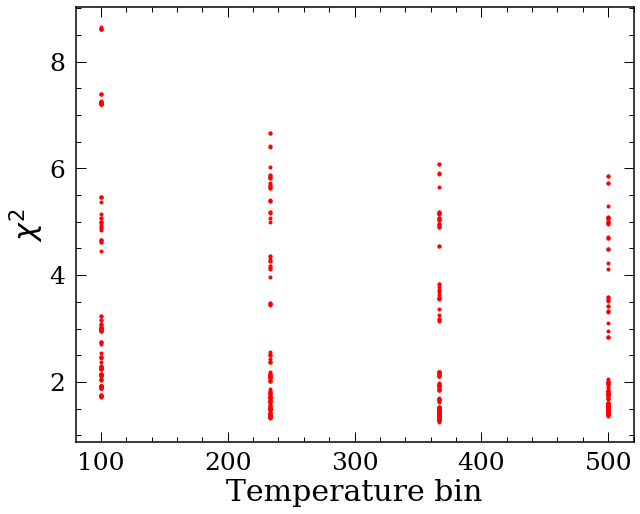

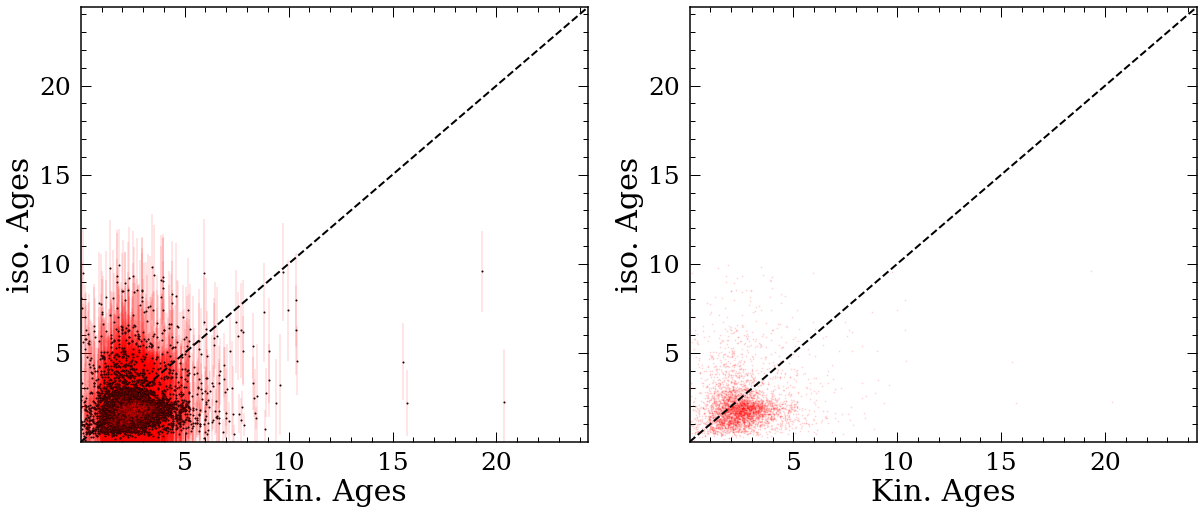

In [24]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a,absg_a)))

print('absg:',absg_a[0],'rvar:',logg_a_s[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])

getkinAges(df_prot_s,['teff_calc','Prot_log','Rvar_log','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


#df_prot_s.to_pickle('minchisq.pkl')


In [5]:
# compare to real ages
import scipy
df_prot_s.dropna(subset=['v_b','teff_calc','Prot_log'])
protbins=np.linspace(0.1,0.5,5)
tempbins=np.linspace(50.,500.,4)
absg=np.linspace(0.01,0.5,4)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for l in absg:
            print(float(count)/float(total))
            count=count+1
            df_prot_s['vel_dis'],df_prot_s['kin_age']=getkinAges(df_prot_s,['teff_calc','Prot_mix_log','abs_G'],[i,j,l])
            stat_df=df_prot_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
            if len(stat_df)<0.8*len(df_prot_s):
                continue
            stat_df=stat_df.loc[stat_df['iso_age']<10]
            stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
            chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err1'])
            chisq.append(chisq_sing/len(stat_df))
            MAD.append(np.median(stat_df['kin_age']-stat_df['iso_age']/
                        np.sqrt(np.power(stat_df['kin_age'],2)+np.power(stat_df['iso_age'],2))))
            tempbins_a.append(i)
            protbins_a.append(j)
            absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  0%|          | 88/77292 [00:00<01:28, 874.43it/s]

0.0125


100%|██████████| 77292/77292 [00:50<00:00, 1543.40it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
  0%|          | 150/77292 [00:00<00:51, 1493.45it/s]

0.025


  0%|          | 146/77292 [00:00<00:52, 1457.28it/s]

0.0375


  0%|          | 124/77292 [00:00<01:02, 1233.94it/s]

0.05


  0%|          | 134/77292 [00:00<00:57, 1338.49it/s]

0.0625


  0%|          | 147/77292 [00:00<00:52, 1469.89it/s]

0.075


  0%|          | 131/77292 [00:00<00:59, 1302.29it/s]

0.0875


  0%|          | 128/77292 [00:00<01:00, 1276.58it/s]

0.1


  0%|          | 157/77292 [00:00<00:49, 1569.33it/s]

0.1125


  0%|          | 109/77292 [00:00<01:11, 1084.05it/s]

0.125


  0%|          | 131/77292 [00:00<00:59, 1302.02it/s]

0.1375


  0%|          | 138/77292 [00:00<00:55, 1379.26it/s]

0.15


  0%|          | 156/77292 [00:00<00:49, 1552.38it/s]

0.1625


  0%|          | 151/77292 [00:00<00:51, 1504.66it/s]

0.175


  0%|          | 128/77292 [00:00<01:00, 1276.17it/s]

0.1875


  0%|          | 141/77292 [00:00<00:54, 1405.95it/s]

0.2


  0%|          | 140/77292 [00:00<00:55, 1393.85it/s]

0.2125


  0%|          | 134/77292 [00:00<00:57, 1331.35it/s]

0.225


  0%|          | 147/77292 [00:00<00:52, 1463.73it/s]

0.2375


  0%|          | 140/77292 [00:00<00:55, 1392.69it/s]

0.25


  0%|          | 138/77292 [00:00<00:56, 1375.92it/s]

0.2625


  0%|          | 150/77292 [00:00<00:51, 1495.42it/s]

0.275


  0%|          | 144/77292 [00:00<00:53, 1435.82it/s]

0.2875


  0%|          | 141/77292 [00:00<00:54, 1405.35it/s]

0.3


  0%|          | 156/77292 [00:00<00:49, 1553.96it/s]

0.3125


  0%|          | 141/77292 [00:00<00:54, 1407.79it/s]

0.325


  0%|          | 137/77292 [00:00<00:56, 1361.33it/s]

0.3375


  0%|          | 116/77292 [00:00<01:06, 1152.10it/s]

0.35


  0%|          | 144/77292 [00:00<00:53, 1436.97it/s]

0.3625


  0%|          | 125/77292 [00:00<01:02, 1243.33it/s]

0.375


  0%|          | 132/77292 [00:00<00:58, 1312.14it/s]

0.3875


  0%|          | 132/77292 [00:00<00:58, 1319.95it/s]

0.4


  0%|          | 155/77292 [00:00<00:49, 1546.31it/s]

0.4125


  0%|          | 121/77292 [00:00<01:04, 1205.76it/s]

0.425


  0%|          | 135/77292 [00:00<00:57, 1341.67it/s]

0.4375


  0%|          | 125/77292 [00:00<01:01, 1245.11it/s]

0.45


  0%|          | 154/77292 [00:00<00:50, 1536.79it/s]

0.4625


  0%|          | 140/77292 [00:00<00:55, 1397.52it/s]

0.475


  0%|          | 112/77292 [00:00<01:09, 1114.37it/s]

0.4875


  0%|          | 121/77292 [00:00<01:04, 1201.83it/s]

0.5


  0%|          | 140/77292 [00:00<00:55, 1395.78it/s]

0.5125


  0%|          | 146/77292 [00:00<00:53, 1455.24it/s]

0.525


  0%|          | 134/77292 [00:00<00:57, 1330.91it/s]

0.5375


  0%|          | 134/77292 [00:00<00:57, 1331.73it/s]

0.55


  0%|          | 157/77292 [00:00<00:49, 1566.49it/s]

0.5625


  0%|          | 138/77292 [00:00<00:56, 1370.75it/s]

0.575


  0%|          | 132/77292 [00:00<00:58, 1315.09it/s]

0.5875


  0%|          | 108/77292 [00:00<01:12, 1069.33it/s]

0.6


  0%|          | 141/77292 [00:00<00:55, 1401.06it/s]

0.6125


  0%|          | 124/77292 [00:00<01:02, 1233.91it/s]

0.625


  0%|          | 123/77292 [00:00<01:02, 1227.14it/s]

0.6375


  0%|          | 85/77292 [00:00<01:32, 839.05it/s]

0.65


  0%|          | 150/77292 [00:00<00:51, 1494.97it/s]

0.6625


  0%|          | 136/77292 [00:00<00:57, 1351.31it/s]

0.675


  0%|          | 123/77292 [00:00<01:02, 1225.00it/s]

0.6875


  0%|          | 113/77292 [00:00<01:08, 1127.03it/s]

0.7


  0%|          | 160/77292 [00:00<00:48, 1598.82it/s]

0.7125


  0%|          | 127/77292 [00:00<01:00, 1266.03it/s]

0.725


  0%|          | 119/77292 [00:00<01:05, 1183.28it/s]

0.7375


  0%|          | 110/77292 [00:00<01:10, 1093.02it/s]

0.75


  0%|          | 157/77292 [00:00<00:49, 1562.16it/s]

0.7625


  0%|          | 74/77292 [00:00<01:45, 734.98it/s]

0.775


  0%|          | 131/77292 [00:00<00:59, 1303.75it/s]

0.7875


  0%|          | 113/77292 [00:00<01:08, 1125.52it/s]

0.8


  0%|          | 151/77292 [00:00<00:51, 1504.07it/s]

0.8125


  0%|          | 140/77292 [00:00<00:55, 1399.65it/s]

0.825


  0%|          | 109/77292 [00:00<01:11, 1087.05it/s]

0.8375


  0%|          | 118/77292 [00:00<01:05, 1170.26it/s]

0.85


  0%|          | 148/77292 [00:00<00:52, 1474.47it/s]

0.8625


  0%|          | 129/77292 [00:00<01:00, 1284.86it/s]

0.875


  0%|          | 121/77292 [00:00<01:03, 1208.10it/s]

0.8875


  0%|          | 115/77292 [00:00<01:07, 1144.51it/s]

0.9


  0%|          | 153/77292 [00:00<00:50, 1529.80it/s]

0.9125


  0%|          | 130/77292 [00:00<00:59, 1295.48it/s]

0.925


  0%|          | 106/77292 [00:00<01:13, 1051.90it/s]

0.9375


  0%|          | 101/77292 [00:00<01:16, 1004.22it/s]

0.95


  0%|          | 154/77292 [00:00<00:50, 1536.65it/s]

0.9625


  0%|          | 102/77292 [00:00<01:16, 1012.87it/s]

0.975


  0%|          | 100/77292 [00:00<01:17, 999.37it/s]

0.9875


  0%|          | 102/77292 [00:00<01:15, 1019.36it/s]

1.0


100%|██████████| 77292/77292 [01:22<00:00, 936.11it/s]


  0%|          | 118/77292 [00:00<01:05, 1176.83it/s]

absg: 0.01 prot: 0.5 temp: 200.0 5.6190382676570625
[200.0, 0.5, 0.01]


100%|██████████| 77292/77292 [00:55<00:00, 1388.75it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'Rotation Period [days]')

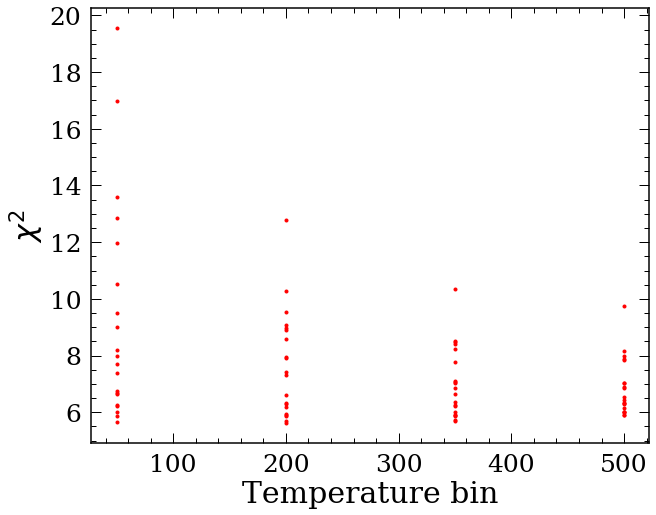

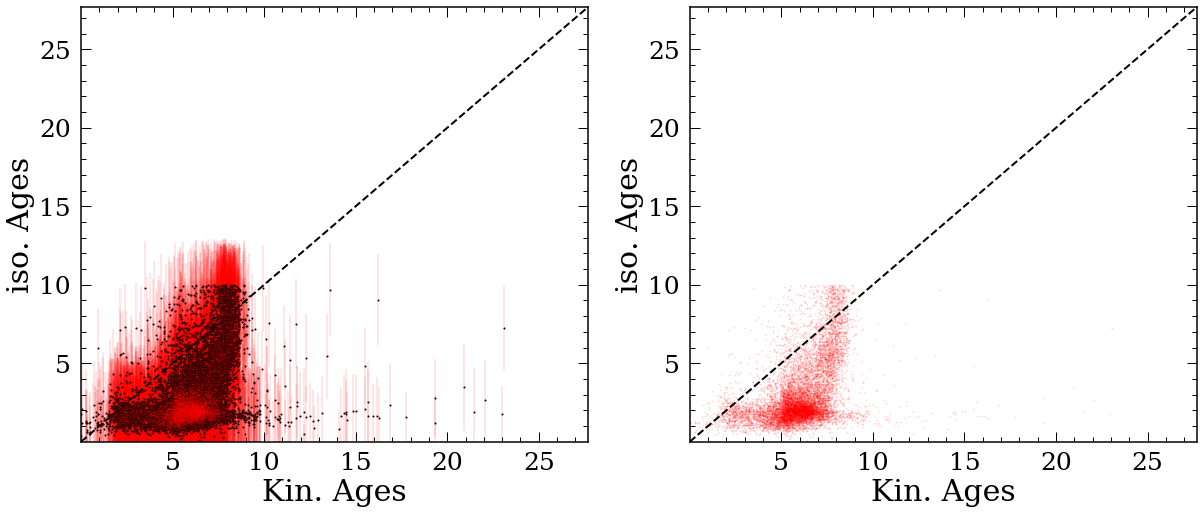

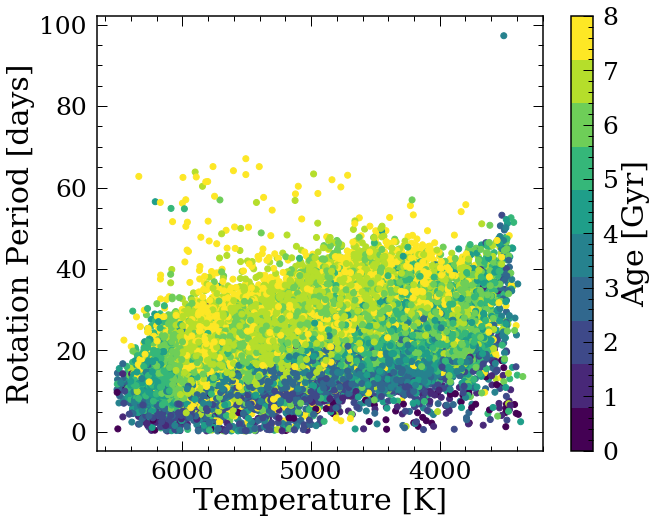

In [8]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,absg_a)))

print('absg:',absg_a[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])
"""
df_prot_s['vel_dis'],df_prot_s['kin_age']=getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])
"""
df_prot_s['vel_dis'],df_prot_s['kin_age']=getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[250.,0.5,0.17])


df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_prot_s['teff_calc'],df_prot_s['Prot_mix'],
            c=df_prot_s['kin_age'],cmap=cm,vmin=0,vmax=8)
cb=plt.colorbar()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')

#df_prot_s.to_pickle('minchisq.pkl')



In [124]:
df_prot_s.to_pickle('minchisq.pkl')

In [101]:
# compare to real ages
import scipy
df_prot_s=df_prot_s.dropna(subset=['v_b','teff_calc','Prot_log'])
protbins=np.linspace(0.1,0.5,5)
tempbins=np.linspace(100.,300.,4)
abs_g=np.linspace(0.1,0.5,4)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
total=len(tempbins)*len(protbins)
count=1
for i in tempbins:
    for j in protbins:
        print(float(count)/float(total))
        count=count+1
        df_prot_s['vel_dis'],df_prot_s['kin_age']=getkinAges(df_prot_s,['teff_calc','Prot_log'],[i,j])
        stat_df=df_prot_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
        if len(stat_df)<1000:
            continue
        stat_df=stat_df.loc[stat_df['iso_age']<10]
        stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
        chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
        chisq.append(chisq_sing/len(stat_df))
        MAD.append(np.median(stat_df['kin_age']-stat_df['iso_age']/
                    np.sqrt(np.power(stat_df['kin_age'],2)+np.power(stat_df['iso_age'],2))))
        tempbins_a.append(i)
        protbins_a.append(j)


  2%|▏         | 340/22361 [00:00<00:06, 3396.67it/s]

0.05


100%|██████████| 22361/22361 [00:05<00:00, 4088.09it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  2%|▏         | 414/22361 [00:00<00:05, 4133.84it/s]

0.1


  2%|▏         | 418/22361 [00:00<00:05, 4179.78it/s]

0.15


  1%|          | 211/22361 [00:00<00:10, 2108.02it/s]

0.2


  2%|▏         | 421/22361 [00:00<00:05, 4205.17it/s]

0.25


  2%|▏         | 373/22361 [00:00<00:05, 3726.42it/s]

0.3


  2%|▏         | 422/22361 [00:00<00:05, 4216.84it/s]

0.35


  2%|▏         | 428/22361 [00:00<00:05, 4270.69it/s]

0.4


  2%|▏         | 405/22361 [00:00<00:05, 4047.69it/s]

0.45


  2%|▏         | 388/22361 [00:00<00:05, 3878.52it/s]

0.5


  2%|▏         | 449/22361 [00:00<00:04, 4488.52it/s]

0.55


  2%|▏         | 413/22361 [00:00<00:05, 4127.64it/s]

0.6


  2%|▏         | 393/22361 [00:00<00:05, 3922.78it/s]

0.65


  2%|▏         | 376/22361 [00:00<00:05, 3756.35it/s]

0.7


  2%|▏         | 342/22361 [00:00<00:06, 3419.41it/s]

0.75


  2%|▏         | 449/22361 [00:00<00:04, 4483.78it/s]

0.8


  2%|▏         | 407/22361 [00:00<00:05, 4065.46it/s]

0.85


  2%|▏         | 375/22361 [00:00<00:05, 3748.80it/s]

0.9


  2%|▏         | 356/22361 [00:00<00:06, 3559.96it/s]

0.95


  2%|▏         | 342/22361 [00:00<00:06, 3418.35it/s]

1.0


100%|██████████| 22361/22361 [00:06<00:00, 3427.93it/s]


In [84]:
df_prot_s[['kin_age','iso_age','iso_age_err1']]

,kin_age,iso_age,iso_age_err1
0,NaN,7.00,7.22
1,NaN,5.12,7.28
2,NaN,5.99,6.15
3,NaN,2.35,3.34
4,NaN,6.95,6.81
...,...,...,...
23153,NaN,9.19,6.93
23154,NaN,8.52,6.88
23155,NaN,8.35,3.79
23156,NaN,4.40,6.04


  1%|          | 197/22361 [00:00<00:11, 1963.44it/s]

prot: 1.0 temp: 350.0 1.2274106773434015
[350.0, 1.0]


100%|██████████| 22361/22361 [00:11<00:00, 2006.01it/s]


Text(0, 0.5, 'Rotation Period [days]')

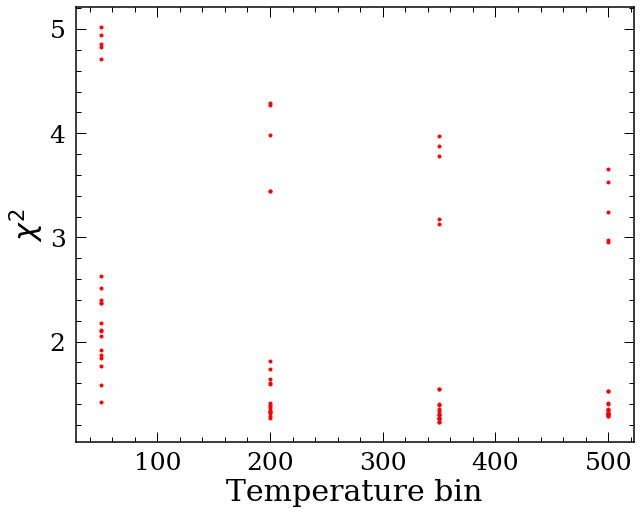

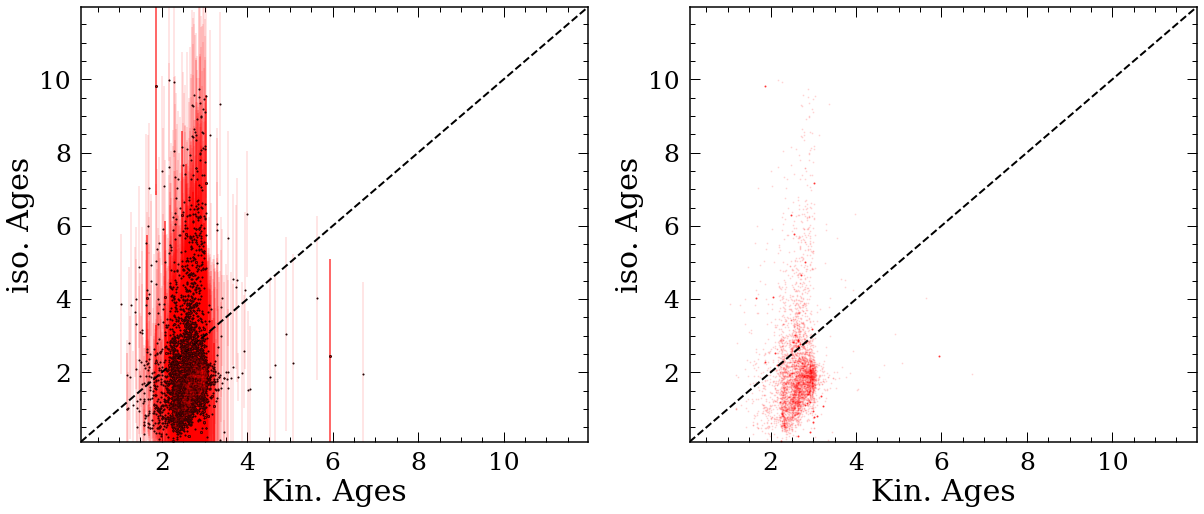

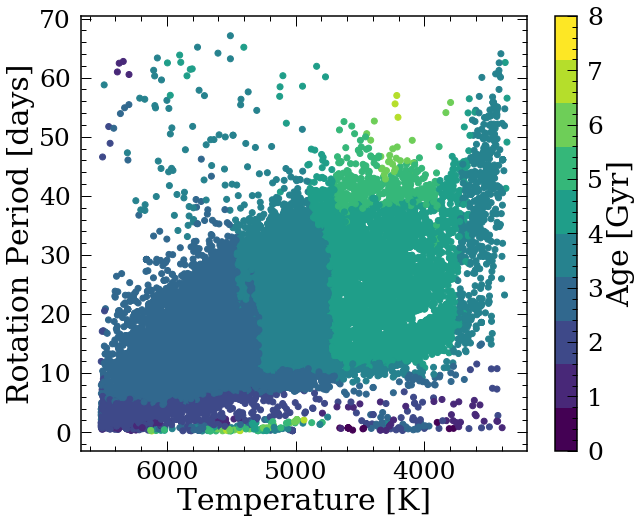

In [129]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a)))

print('prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0]])

df_prot_s['vel_dis'],df_prot_s['kin_age']=getkinAges(df_prot_s,['teff_calc','Prot_log'],
           [tempbin_a_s[0],rotbin_a_s[0]])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_prot_s['teff_calc'],df_prot_s['Prot'],
            c=df_prot_s['kin_age'],cmap=cm,vmin=0,vmax=8)
cb=plt.colorbar()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')
#df_prot_s.to_pickle('minchisq.pkl')




## average ages (real chisq)

In [ ]:
# get average ages in a bin
import scipy

tempbins=[400.,500.,600.,700.,800,900,1000]
protbins=[0.3,0.4,0.5,0.6,0.7]
loggbins=[0.1,0.2,0.5,0.7,0.8]
chisq=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            print(float(count)/float(total))
            count=count+1
            getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[i,j,k])
            df_prot_s=df_prot_s.dropna(subset=['kin_age','iso_age_ave','iso_age_ave_err'])
            stat_df=df_prot_s.loc[df_prot_s['iso_age']<10]
            chisq_single=sum(np.power(stat_df['kin_age']-stat_df['iso_age_ave'],2.)/stat_df['iso_age_ave_err'])
            chisq.append(chisq_single)
            tempbins_a.append(i)
            protbins_a.append(j)
            loggbins_a.append(k)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

100%|██████████| 22361/22361 [00:11<00:00, 1872.87it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


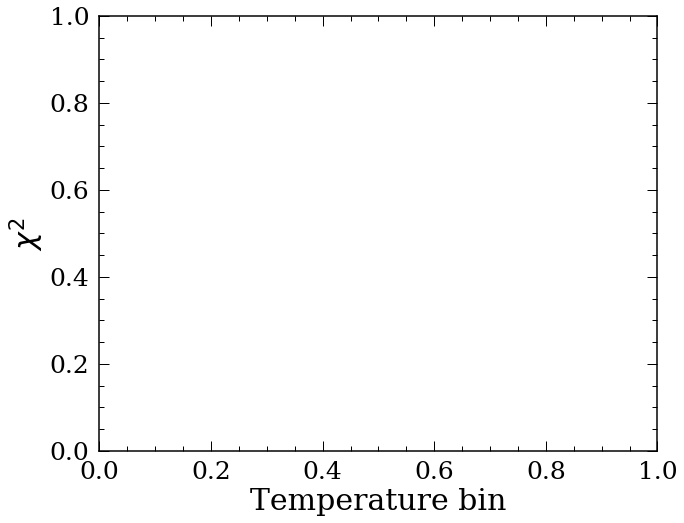

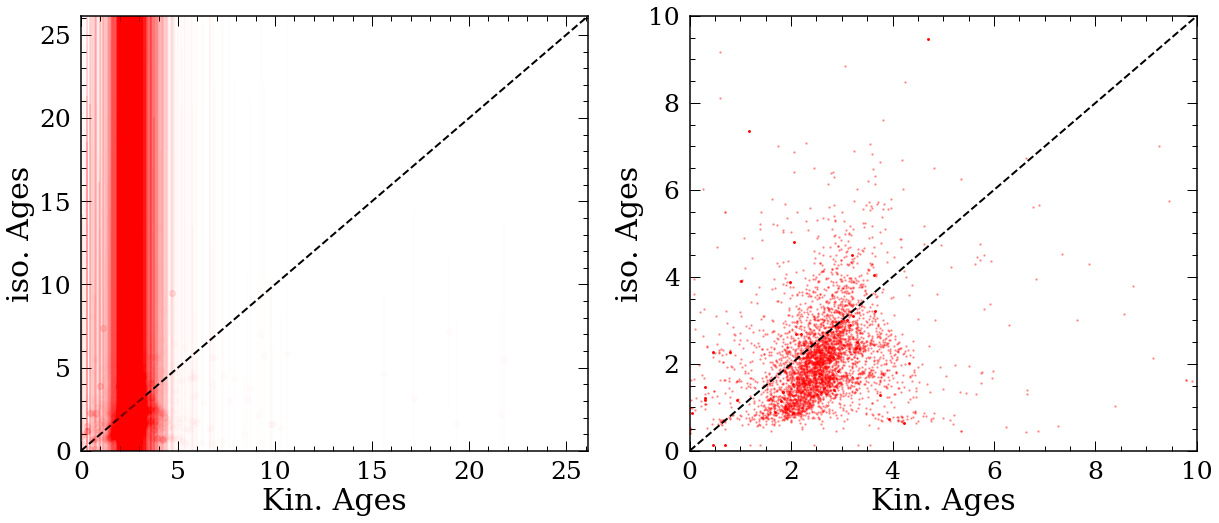

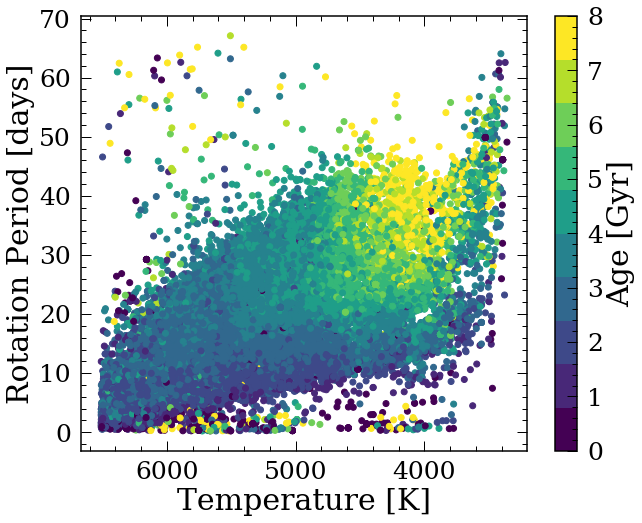

In [166]:
plt.figure(figsize=(10,8))
#plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

#chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a)))

#print(logg_a_s[0],rotbin_a_s[0],tempbin_a_s[0],chisq_s[0])

#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[100,0.4,0.5])
kinage,df_prot_s['iso_age_ave'],df_prot_s['iso_age_ave_err']=getAveAges(df_prot_s,
                                                    ['teff_calc','Prot_log','abs_G'],[350.0, 0.5, 0.17333333333333334])


df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age_ave'],
             yerr=df_prot_s_plot['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_prot_s_plot['iso_age_ave']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age_ave']),max(df_prot_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age_ave'],'r.',alpha=0.3,markersize=3)
minage=min(min(df_prot_s_plot['iso_age_ave']),min(df_prot_s_plot['kin_age']))
maxage=max(max(df_prot_s_plot['iso_age_ave']),max(df_prot_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_prot_s['teff_calc'],df_prot_s['Prot'],
            c=df_prot_s['kin_age'],cmap=cm,vmin=0,vmax=8)
cb=plt.colorbar()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')

df_prot_s.to_pickle('minchisq.pkl')

# For Rvars

## real ages (real chisq)

In [167]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')

In [197]:
# compare to real ages
import scipy

protbins=np.linspace(0.1,1.5,5)
tempbins=np.linspace(100.,500.,4)
absg=np.linspace(0.1,1,5)

df_rvar_s['iso_age_err']=np.sqrt(df_rvar_s['iso_age_err1']**2.+df_rvar_s['iso_age_err2']**2.)

chisq=[]
tempbins_a=[]
protbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for l in absg:
            print(float(count)/float(total))
            count=count+1
            df_rvar_s['vel_dis'],df_rvar_s['kin_age']=getkinAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],[i,j,l])
            stat_df=df_rvar_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
            if len(stat_df)<0.8*len(df_rvar_s):
                continue
            stat_df=stat_df.loc[stat_df['iso_age']<10]
            stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
            chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
            chisq.append(chisq_sing/len(stat_df))
                
            tempbins_a.append(i)
            protbins_a.append(j)
            absg_a.append(l)


  0%|          | 112/87270 [00:00<01:17, 1119.12it/s]

0.01


100%|██████████| 87270/87270 [01:03<00:00, 1383.05it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 142/87270 [00:00<01:01, 1411.52it/s]

0.02


  0%|          | 146/87270 [00:00<00:59, 1453.70it/s]

0.03


  0%|          | 144/87270 [00:00<01:00, 1436.24it/s]

0.04


  0%|          | 145/87270 [00:00<01:00, 1445.40it/s]

0.05


  0%|          | 147/87270 [00:00<00:59, 1463.88it/s]

0.06


  0%|          | 142/87270 [00:00<01:01, 1416.06it/s]

0.07


  0%|          | 106/87270 [00:00<01:22, 1053.70it/s]

0.08


  0%|          | 117/87270 [00:00<01:14, 1165.23it/s]

0.09


  0%|          | 88/87270 [00:00<01:40, 868.16it/s]

0.1


  0%|          | 128/87270 [00:00<01:08, 1279.63it/s]

0.11


  0%|          | 141/87270 [00:00<01:01, 1408.94it/s]

0.12


  0%|          | 137/87270 [00:00<01:03, 1362.79it/s]

0.13


  0%|          | 127/87270 [00:00<01:08, 1266.80it/s]

0.14


  0%|          | 124/87270 [00:00<01:10, 1236.45it/s]

0.15


  0%|          | 135/87270 [00:00<01:04, 1342.68it/s]

0.16


  0%|          | 138/87270 [00:00<01:03, 1377.79it/s]

0.17


  0%|          | 143/87270 [00:00<01:01, 1426.62it/s]

0.18


  0%|          | 96/87270 [00:00<01:31, 957.54it/s]

0.19


  0%|          | 113/87270 [00:00<01:17, 1121.39it/s]

0.2


  0%|          | 143/87270 [00:00<01:01, 1421.68it/s]

0.21


  0%|          | 137/87270 [00:00<01:03, 1366.53it/s]

0.22


  0%|          | 131/87270 [00:00<01:06, 1301.94it/s]

0.23


  0%|          | 129/87270 [00:00<01:07, 1282.00it/s]

0.24


  0%|          | 112/87270 [00:00<01:17, 1117.54it/s]

0.25


  0%|          | 153/87270 [00:00<00:57, 1526.53it/s]

0.26


  0%|          | 160/87270 [00:00<00:54, 1592.29it/s]

0.27


  0%|          | 116/87270 [00:00<01:15, 1155.46it/s]

0.28


  0%|          | 153/87270 [00:00<00:57, 1526.29it/s]

0.29


  0%|          | 155/87270 [00:00<00:56, 1543.43it/s]

0.3


  0%|          | 148/87270 [00:00<00:59, 1472.30it/s]

0.31


  0%|          | 133/87270 [00:00<01:05, 1326.07it/s]

0.32


  0%|          | 140/87270 [00:00<01:02, 1393.34it/s]

0.33


  0%|          | 105/87270 [00:00<01:23, 1042.03it/s]

0.34


  0%|          | 107/87270 [00:00<01:21, 1065.77it/s]

0.35


  0%|          | 138/87270 [00:00<01:03, 1376.39it/s]

0.36


  0%|          | 93/87270 [00:00<01:33, 929.51it/s]

0.37


  0%|          | 119/87270 [00:00<01:13, 1183.15it/s]

0.38


  0%|          | 115/87270 [00:00<01:15, 1147.88it/s]

0.39


  0%|          | 116/87270 [00:00<01:15, 1152.92it/s]

0.4


  0%|          | 140/87270 [00:00<01:02, 1397.64it/s]

0.41


  0%|          | 122/87270 [00:00<01:11, 1213.33it/s]

0.42


  0%|          | 120/87270 [00:00<01:12, 1195.55it/s]

0.43


  0%|          | 115/87270 [00:00<01:16, 1142.87it/s]

0.44


  0%|          | 117/87270 [00:00<01:14, 1169.82it/s]

0.45


  0%|          | 139/87270 [00:00<01:02, 1384.15it/s]

0.46


  0%|          | 118/87270 [00:00<01:13, 1179.70it/s]

0.47


  0%|          | 115/87270 [00:00<01:15, 1147.60it/s]

0.48


  0%|          | 106/87270 [00:00<01:22, 1059.69it/s]

0.49


  0%|          | 106/87270 [00:00<01:22, 1059.94it/s]

0.5


  0%|          | 157/87270 [00:00<00:55, 1562.16it/s]

0.51


  0%|          | 120/87270 [00:00<01:13, 1192.02it/s]

0.52


  0%|          | 113/87270 [00:00<01:17, 1128.58it/s]

0.53


  0%|          | 110/87270 [00:00<01:19, 1098.41it/s]

0.54


  0%|          | 111/87270 [00:00<01:18, 1108.07it/s]

0.55


  0%|          | 109/87270 [00:00<01:20, 1087.75it/s]

0.56


  0%|          | 130/87270 [00:00<01:07, 1297.68it/s]

0.57


  0%|          | 99/87270 [00:00<01:28, 984.88it/s]

0.58


  0%|          | 91/87270 [00:00<01:35, 908.24it/s]

0.59


  0%|          | 115/87270 [00:00<01:15, 1146.88it/s]

0.6


  0%|          | 139/87270 [00:00<01:02, 1389.21it/s]

0.61


  0%|          | 113/87270 [00:00<01:17, 1120.39it/s]

0.62


  0%|          | 113/87270 [00:00<01:17, 1127.34it/s]

0.63


  0%|          | 91/87270 [00:00<01:37, 898.55it/s]

0.64


  0%|          | 96/87270 [00:00<01:31, 948.97it/s]

0.65


  0%|          | 135/87270 [00:00<01:04, 1345.79it/s]

0.66


  0%|          | 100/87270 [00:00<01:27, 992.24it/s]

0.67


  0%|          | 102/87270 [00:00<01:26, 1011.41it/s]

0.68


  0%|          | 97/87270 [00:00<01:30, 964.61it/s]

0.69


  0%|          | 99/87270 [00:00<01:28, 981.33it/s]

0.7


  0%|          | 131/87270 [00:00<01:06, 1301.96it/s]

0.71


  0%|          | 120/87270 [00:00<01:12, 1194.60it/s]

0.72


  0%|          | 98/87270 [00:00<01:29, 974.96it/s]

0.73


  0%|          | 96/87270 [00:00<01:31, 951.66it/s]

0.74


  0%|          | 93/87270 [00:00<01:34, 924.74it/s]

0.75


  0%|          | 153/87270 [00:00<00:57, 1524.24it/s]

0.76


  0%|          | 132/87270 [00:00<01:06, 1311.91it/s]

0.77


  0%|          | 143/87270 [00:00<01:01, 1419.72it/s]

0.78


  0%|          | 138/87270 [00:00<01:03, 1379.46it/s]

0.79


  0%|          | 138/87270 [00:00<01:03, 1376.12it/s]

0.8


  0%|          | 141/87270 [00:00<01:02, 1404.06it/s]

0.81


  0%|          | 132/87270 [00:00<01:06, 1313.06it/s]

0.82


  0%|          | 121/87270 [00:00<01:12, 1209.77it/s]

0.83


  0%|          | 116/87270 [00:00<01:15, 1159.83it/s]

0.84


  0%|          | 103/87270 [00:00<01:25, 1024.86it/s]

0.85


  0%|          | 138/87270 [00:00<01:03, 1372.48it/s]

0.86


  0%|          | 113/87270 [00:00<01:17, 1126.81it/s]

0.87


  0%|          | 110/87270 [00:00<01:19, 1094.65it/s]

0.88


  0%|          | 101/87270 [00:00<01:26, 1007.56it/s]

0.89


  0%|          | 98/87270 [00:00<01:29, 971.64it/s]

0.9


  0%|          | 138/87270 [00:00<01:03, 1377.38it/s]

0.91


  0%|          | 124/87270 [00:00<01:10, 1233.55it/s]

0.92


  0%|          | 104/87270 [00:00<01:24, 1034.10it/s]

0.93


  0%|          | 96/87270 [00:00<01:31, 957.17it/s]

0.94


  0%|          | 91/87270 [00:00<01:35, 908.61it/s]

0.95


  0%|          | 141/87270 [00:00<01:02, 1401.38it/s]

0.96


  0%|          | 119/87270 [00:00<01:13, 1188.80it/s]

0.97


  0%|          | 100/87270 [00:00<01:28, 989.34it/s]

0.98


  0%|          | 92/87270 [00:00<01:35, 915.78it/s]

0.99


  0%|          | 83/87270 [00:00<01:45, 827.66it/s]

1.0


100%|██████████| 87270/87270 [01:47<00:00, 814.21it/s]


  0%|          | 109/87270 [00:00<01:20, 1086.91it/s]

absg: 1.0 Rvar: 1.5 temp: 100.0 3.6331663252420063
[100.0, 1.5, 1.0]


100%|██████████| 87270/87270 [01:15<00:00, 1151.29it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Photometric Variability [ppm]')

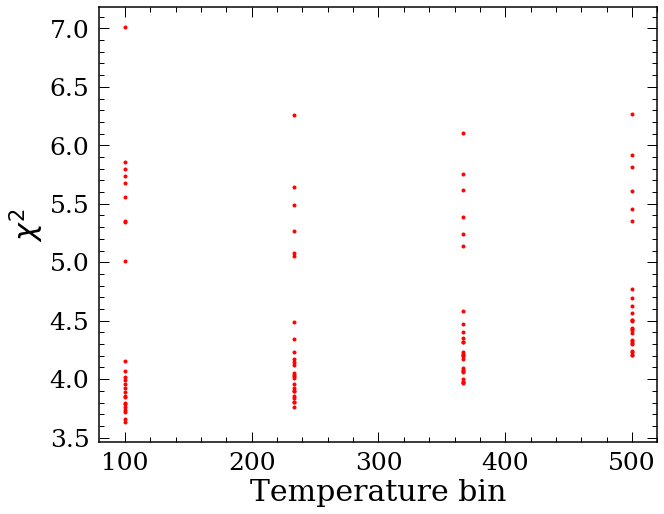

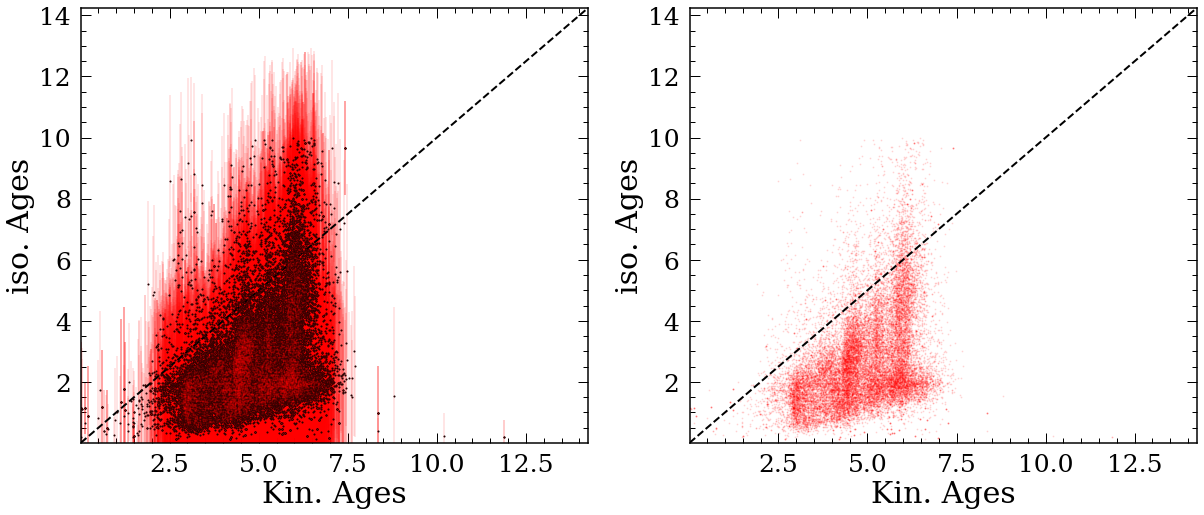

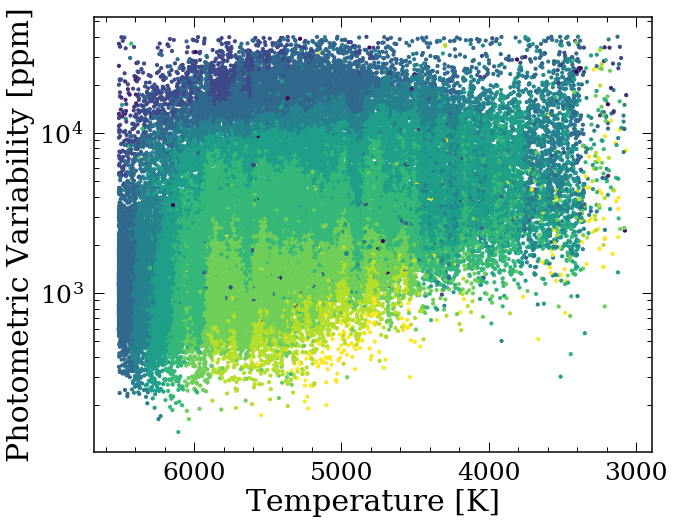

In [198]:
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')
df_rvar_s=df_rvar_s.dropna(subset=['Rvar_log','teff_calc','v_b'])
chisq_s,rotbin_a_s,tempbin_a_s,absg_a=zip(*sorted(zip(chisq,protbins_a,tempbins_a,absg_a)))

print('absg:',absg_a[0],'Rvar:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])
"""
getkinAges(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [266.6666666666667, 0.5, 0.4175, 0.01])

df_rvar_s['vel_dis'],df_rvar_s['kin_age']=getkinAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],
           [266.6666666666667, 2, 0.1])
"""
df_rvar_s['vel_dis'],df_rvar_s['kin_age']=getkinAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])

df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
             yerr=df_rvar_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
         'ko',alpha=1,markersize=1)
minage=min(min(df_rvar_s_plot['iso_age']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age']),max(df_rvar_s_plot['kin_age']))

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_rvar_s['teff_calc'],df_rvar_s['Rvar'],c=df_rvar_s['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.ylabel('Photometric Variability [ppm]')

#df_rvar_s.to_pickle('minchisq_rvar.pkl')



In [183]:
df_rvar_s['v_b']

0       -33.411547
1        -4.214296
2        36.144482
3        26.448217
4        -0.966857
           ...    
88409    18.829108
88410   -10.180756
88411     4.480242
88412    -0.407244
88413    24.320181
Name: v_b, Length: 87270, dtype: float64

In [28]:
df_rvar_s.loc[df_rvar_s['KID']==11075611]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
73535,11075611,0.539,0.013,-0.013,3761.3,77.3,-77.3,4.686,0.013,-0.013,...,11075611,4.530539,4689.908028,3504.631839,3.671164,4.917,-9.770699,8.817705,9.117511,4.346705


In [29]:
df_rvar_s.loc[df_rvar_s['KID']==12456401]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
84040,12456401,0.526,0.012,-0.013,3809.6,81.2,-71.5,4.704,0.012,-0.012,...,12456401,4.385001,4237.663746,3679.311078,3.627126,4.826,7.88599,8.63656,9.347304,2.313152


In [200]:
kinage,df_rvar_s['iso_age_ave'],df_rvar_s['iso_age_ave_err']=getAveAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],
           [100.0, 1.5, 1.0])



100%|██████████| 87270/87270 [02:43<00:00, 533.73it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


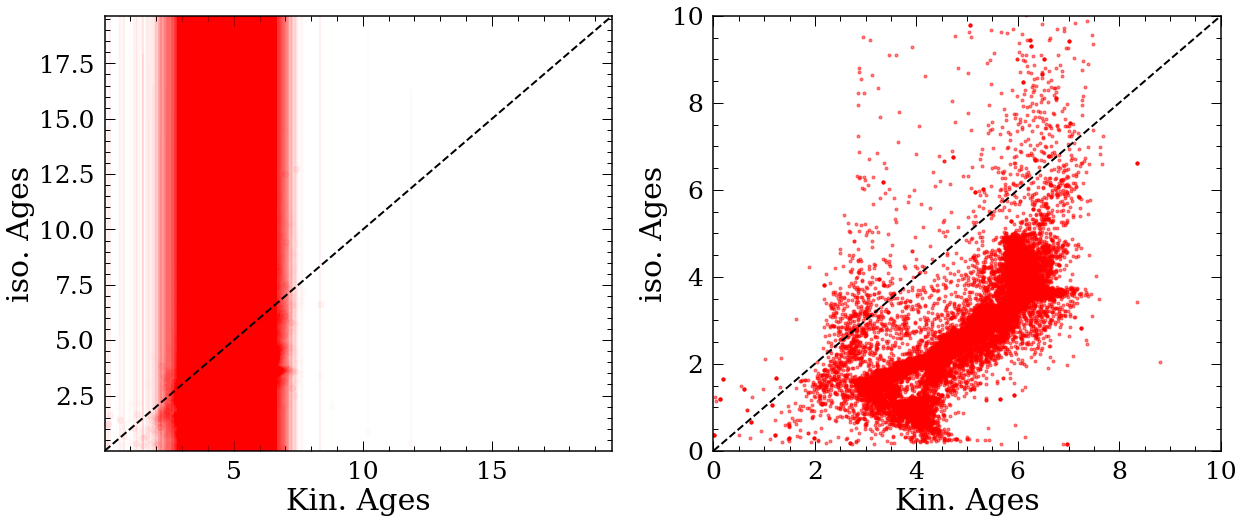

In [201]:
df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],yerr=df_rvar_s_plot['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],'r.',alpha=0.5)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.savefig('wologg.png')
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [39]:

    

ages=getkinAges_err(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]],sampsize=50) 



100%|██████████| 84824/84824 [01:20<00:00, 1051.85it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 84824/84824 [01:25<00:00, 986.87it/s] 


(array([25., 14.,  5.,  1.,  0.,  0.,  1.,  1.,  2.,  1.]),
 array([5.54410196, 5.73763689, 5.93117181, 6.12470674, 6.31824166,
        6.51177659, 6.70531151, 6.89884643, 7.09238136, 7.28591628,
        7.47945121]),
 <a list of 10 Patch objects>)

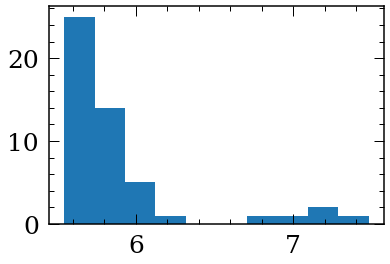

In [81]:
plt.hist(ages[10,:])

In [3]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age,iso_age_ave,iso_age_ave_err,kin_age_err,source_id
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,4.335097,4.500,-33.411547,5.517761,7.433176,6.050929,6.389688,759.97,0.671505,2.050232e+18
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,3.505987,4.574,-4.214296,6.159685,8.361459,5.329557,6.602250,496.15,0.834650,2.050232e+18
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,3.252893,4.547,36.144482,5.998116,7.047929,5.374382,9.921913,443.54,1.041803,2.050236e+18
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,3.464520,4.560,26.448217,6.161795,8.510323,4.650196,6.560067,469.66,1.334890,2.050233e+18
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,4.180735,4.615,-0.966857,6.411296,8.748257,2.800943,7.478731,388.49,0.448719,2.050232e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84819,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,3.449165,4.500,18.829108,6.176964,6.371766,3.519965,15.195308,59.82,1.223089,2.139326e+18
84820,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,3.255194,4.571,-10.180756,4.676241,4.325101,3.603349,16.875361,64.17,0.613842,2.139336e+18
84821,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,3.309001,4.423,4.480242,4.376738,3.396115,6.606545,4.493451,475.13,0.684779,2.139336e+18
84822,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,4.028109,4.579,-0.407244,5.892401,8.148325,6.852331,9.580305,574.14,0.544911,2.139342e+18


In [46]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')

In [56]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [50]:
age_err=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_rvar_s))] 

In [51]:
df_rvar_s['kin_age_err']=age_err

In [55]:
df_rvar_s=pd.merge(df_rvar_s,pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')[['KID','source_id']],left_on='KID',right_on='KID',how='inner')

In [54]:
df_rvar_p

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,iso_gof,TAMS\\,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,1.0,16.1\\,757450,3.169943,21632.027626,5313.795979,4.335097,4.500,-33.411547,5.517761
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,1.0,23.06\\,892718,4.666500,3206.175566,5058.354128,3.505987,4.574,-4.214296,6.159685
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,1.0,24.12\\,892772,4.925885,1790.165901,4898.417653,3.252893,4.547,36.144482,5.998116
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,1.0,23.42\\,892832,4.717011,2914.205194,5059.657160,3.464520,4.560,26.448217,6.161795
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,1.0,27.05\\,892834,3.633430,15161.266923,4856.095860,4.180735,4.615,-0.966857,6.411296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84820,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,1.0,27.52\\,12935144,4.581993,2812.966704,4623.859643,3.449165,4.500,18.829108,6.176964
84821,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,1.0,15.52\\,12983952,4.896960,1799.672842,5347.731327,3.255194,4.571,-10.180756,4.676241
84822,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,1.0,7.49\\,12984012,4.455203,2037.048340,6043.922841,3.309001,4.423,4.480242,4.376738
84823,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,1.0,22.31\\,12984138,4.025700,10668.635368,5044.668752,4.028109,4.579,-0.407244,5.892401


In [83]:
list(pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl').columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g

In [202]:
#df=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')
df=pd.read_pickle('KinageAllKepler.pkl')

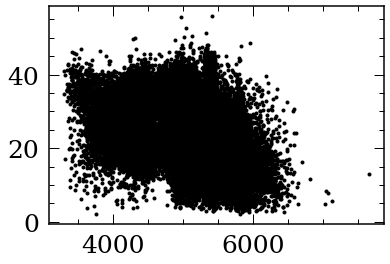

In [204]:
plt.plot(df['teff_val'],df['Prot_predict'],'k.')

In [205]:
def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX



In [ ]:
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)


In [12]:
np.shape(px_s)

(88561, 10000)

In [206]:
testing=10000
vts=np.zeros((len(df),testing))
vbs=np.zeros((len(df),testing))
for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,1)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,1)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,1)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,1)
    vts[:,i],vbs[:,i]=getVs(px_s[:,0],pmra_s[:,0],pmdec_s[:,0],ra_s[:,0],dec_s[:,0])
    
    

100%|██████████| 10000/10000 [5:36:07<00:00,  2.02s/it] 


In [207]:
vt_err=np.zeros(len(df))
vb_err=np.zeros(len(df))

for i in trange(len(df)):
    vt_err[i]=np.std(vts[i,:])
    vb_err[i]=np.std(vbs[i,:])

100%|██████████| 77292/77292 [02:21<00:00, 546.60it/s] 


In [208]:
df['v_t_err']=vt_err
df['v_b_err']=vb_err


In [221]:
df

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G,Prot_predict,Prot_log,vel_dis,kin_age,predict_kin_age,v_t_err,v_b_err,abs_G_err,teff_val_err
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,5.168635,15.501700,1.190379,11.066371,2.683424,2.512550,0.785521,0.775960,0.048773,95.500000
1,892203,0.967,0.073,-0.074,5712.8,108.3,-105.3,4.386,0.042,-0.044,...,4.614045,35.644433,1.551992,23.068715,8.534530,3.765481,0.140177,0.139020,0.018856,194.583252
2,892675,1.038,0.066,-0.076,5929.4,108.9,-108.1,4.385,0.035,-0.043,...,4.335745,24.021617,1.380602,21.229712,7.487737,3.583062,0.298697,0.235684,0.018498,101.993408
3,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,5.937777,30.116367,1.478803,21.363975,7.562462,3.835122,1.703463,0.336419,0.072925,41.750000
4,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,5.794667,35.386367,1.548836,19.904485,6.764850,4.028645,2.247923,1.892400,0.108308,130.961426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77287,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,6.117139,35.200850,1.546553,21.036548,7.380707,4.644930,1.461758,0.368436,0.038003,90.559814
77288,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,4.418595,33.136000,1.520300,20.100568,6.870115,3.847322,0.719324,0.388529,0.057960,91.278564
77289,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,4.076116,17.330283,1.238806,18.732062,6.147941,2.957470,2.725900,0.378706,0.074624,287.665039
77290,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,5.670720,14.285717,1.154902,10.771081,2.571510,2.908418,0.287878,0.308663,0.064555,75.750000


In [222]:
df.to_pickle('KinageAllKepler.pkl')

In [212]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

In [213]:
testing=10000
absg_err=np.zeros((len(df),testing))

for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,0])


100%|██████████| 10000/10000 [54:47<00:00,  3.04it/s] 


In [214]:
absg_err_err=np.zeros(len(df))
for i in trange(len(df)):
    absg_err_err[i]=np.std(absg_err[i,:])

100%|██████████| 77292/77292 [00:38<00:00, 2006.95it/s]


In [215]:
df['abs_G_err']=absg_err_err

In [47]:
#add_col=['v_t_err','v_b_err','abs_G_err']
add_col=['designation']
columns_non=[i for i in df_rvar_s.columns if i not in add_col]
len(columns_non)

57

In [48]:
df_rvar_s=pd.merge(df_rvar_s[columns_non],df[np.append(['KID'],add_col)],left_on='KID',right_on='KID',how='inner')

In [49]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,designation
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038,Gaia DR2 2050231848829944320
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106,Gaia DR2 2050232364226074624
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199,Gaia DR2 2050235731480463616
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337,Gaia DR2 2050232776542967680
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647,Gaia DR2 2050232089348169856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935,Gaia DR2 2139325653978247808
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811,Gaia DR2 2139336408576560512
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621,Gaia DR2 2139336099338925312
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518,Gaia DR2 2139341768695774336


In [52]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [15]:
df['teff_calc']

0        5313.795979
1        3783.045568
2        5058.354128
3        4898.417653
4        5059.657160
            ...     
88556    5347.731327
88557    6043.922841
88558    5044.668752
88559    5305.874615
88560    5180.812805
Name: teff_calc, Length: 88561, dtype: float64

In [220]:
df['teff_val_err']=(df['teff_percentile_upper']-df['teff_percentile_lower'])/2.
df['teff_val_err']


0         95.500000
1        194.583252
2        101.993408
3         41.750000
4        130.961426
            ...    
77287     90.559814
77288     91.278564
77289    287.665039
77290     75.750000
77291     60.407471
Name: teff_val_err, Length: 77292, dtype: float64

In [17]:
df_rvar_s=pd.merge(df_rvar_s,df[np.append(['KID'],['teff_val_err'])],left_on='KID',right_on='KID',how='inner')



In [50]:
pd.read_pickle('minchisq_rvar.pkl')

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,v_b_err,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.768051,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.333401,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,1.886702,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.730871,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.129022,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.368733,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.394648,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.386915,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.314944,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518


In [51]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,designation
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038,Gaia DR2 2050231848829944320
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106,Gaia DR2 2050232364226074624
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199,Gaia DR2 2050235731480463616
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337,Gaia DR2 2050232776542967680
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647,Gaia DR2 2050232089348169856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935,Gaia DR2 2139325653978247808
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811,Gaia DR2 2139336408576560512
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621,Gaia DR2 2139336099338925312
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518,Gaia DR2 2139341768695774336
